In [1]:
# !pip install tensorflow

In [3]:
import tensorflow as tf
import math
pi = tf.constant(math.pi)

##############################################################################

acc = lambda TN,FP,FN,TP: tf.math.divide_no_nan(TP+TN,TN+FP+FN+TP)
prec = lambda TN,FP,FN,TP: tf.math.divide_no_nan(TP,FP+TP)
rec = lambda TN,FP,FN,TP: tf.math.divide_no_nan(TP,FN+TP)
spec = lambda TN,FP,FN,TP: tf.math.divide_no_nan(TN,FP+TN)
f1s = lambda TN,FP,FN,TP: 2.*tf.math.divide_no_nan(prec(TN,FP,FN,TP)*\
                          rec(TN,FP,FN,TP),prec(TN,FP,FN,TP)+rec(TN,FP,FN,TP))
tss = lambda TN,FP,FN,TP: rec(TN,FP,FN,TP)+spec(TN,FP,FN,TP)-1.
csi = lambda TN,FP,FN,TP: tf.math.divide_no_nan(TP,FN+FP+TP)
hss1 = lambda TN,FP,FN,TP: tf.math.divide_no_nan(TP-FP,FN+TP)
hss2 = lambda TN,FP,FN,TP: tf.math.divide_no_nan(2.*((TP*TN)-(FP*FN)),((TP+FN)\
                            *(FN+TN))+((TP+FP)*(TN+FP)))
bacc = lambda TN,FP,FN,TP: tf.math.divide_no_nan(rec(TN,FP,FN,TP)+spec(TN,FP,FN,TP),2.0)
    
F_unif = lambda x: x
F_cos = lambda x,mu,delta: tf.where(x<mu-delta,0.,tf.where(x>mu+delta,1.,\
        0.5*(1.+tf.math.divide(x-mu,delta)+1./pi*tf.math.sin(pi*\
         tf.math.divide(x-mu,delta)))))



def SOL(score = 'accuracy', distribution = 'uniform',\
        mu = 0.5, delta = 0.1, mode = 'average'):

    """
    
    Score-Oriented Loss (SOL)

    Compute the expected confusion matrix defined by the following elements
           n
      TP = ∑  y_i * F(p_i)
           n
      TN = ∑  (1 - y_i) * (1 - F(p_i))
          i=1
           n
      FP = ∑  (1 - y_i) * F(p_i)
          i=1
           n
      FN = ∑  y_i * (1 - F(p_i))
          i=1

      where y_i represents the true label, p_i represents the predicted probability given by p_i = sigmoid(x_i) and
      F represents the a priori distribution for the threshold.

      The Score-Oriented loss is defined on the elements of the expected confusion matrix as follows

      loss = - score(TP,TN,FP,FN) + 1,

      where score represents the chosen skill score.

      Example
      if score = 'accuracy'
      then
      loss = - (TP + TN) / (TP + FN + TN + FP) + 1
    
    Authors: Guastavino S. & Marchetti F.

    References: https://arxiv.org/abs/2103.15522

    Usage:
     model.compile(loss=SOL(score = 'accuracy', distribution = 'uniform', mu = 0.5, delta = 0.1, mode = 'average'))

    Parameters
    ----------
    
    score : string, the chosen score used to build the loss. Implemented 
            choices are ['accuracy','precision','recall','specificity',
            'f1_score','tss','csi','hss1','hss2'].
    
    distribution : string, the a priori distribution for the threshold.
                   Implemented choices are ['uniform','cosine'].
             
    mu : scalar in (0,1) or list of scalars in (0,1). If the chosen 
         distribution is 'cosine', mu is the mean of the raised cosine 
         distribution. In the multiclass case, mu can be defined as a list of
         values, one for each one-vs-rest classification, so that
         len(mu) = number of classes. 
         If the the chosen distribution is 'uniform', this parameter is
         ignored.
    
    delta : scalar in (0,1). If the chosen distribution is 'cosine', then
            [mu-delta,mu+delta] is the support of the raised cosine
            distribution. In the multiclass case, delta can be defined as a
            list values, one for each one-vs-rest classification, so that
            len(delta) = number of classes. 
            If the the chosen distribution is 'uniform', this parameter is
            ignored.
    
    mode : string in ['average','weighted']. In the multiclass case, it 
           determines in which way the contributes of the one-vs-rest tasks
           are combined in a unique score. 
           If the problem is not multiclass, this parameter is ignored.
    
    
    """
        
    if score == 'accuracy':
        score = acc
    if score == 'precision':
        score = prec
    if score == 'recall':
        score = rec    
    if score == 'specificity':
        score = spec        
    if score == 'f1_score':
        score = f1s
    if score == 'tss':
        score = tss
    if score == 'csi':
        score = csi
    if score == 'hss1':
        score = hss1        
    if score == 'hss2':
        score = hss2 
    if score == 'bacc':
        score = bacc
        
    if distribution == 'uniform':
        distr = F_unif
        
    if distribution == 'cosine':
        if type(mu) is not list:
            distr = lambda x: F_cos(x,mu,delta)
        else:
            distr = [lambda x: F_cos(x,mu[j],delta[j]) for j in \
                     range(0,len(mu))]
            
    def SOL_(y_true, y_pred):
                
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        
        if y_pred.shape[1] == 1:   
            
            TN = tf.reduce_sum((1.-y_true)*(1.-distr(y_pred)))
            TP = tf.reduce_sum(y_true*distr(y_pred))
            FP = tf.reduce_sum((1.-y_true)*distr(y_pred))
            FN = tf.reduce_sum(y_true*(1.-distr(y_pred)))
        
            return -score(TN,FP,FN,TP) + 1.
        
        else:
            
            score_arr = []
            num_c0_arr = []
            
            
            for j in range(0,y_pred.shape[1]):
                                 
                y_pred_ = y_pred[:,j]
                y_true_ = y_true[:,j]
                
                if type(mu) is not list:

                    TN = tf.reduce_sum((1.-y_true_)*(1.-distr(y_pred_)))
                    TP = tf.reduce_sum(y_true_*distr(y_pred_))
                    FP = tf.reduce_sum((1.-y_true_)*distr(y_pred_))
                    FN = tf.reduce_sum(y_true_*(1.-distr(y_pred_)))
                
                else:
                
                    TN = tf.reduce_sum((1.-y_true_)*(1.-distr[j](y_pred_)))
                    TP = tf.reduce_sum(y_true_*distr[j](y_pred_))
                    FP = tf.reduce_sum((1.-y_true_)*distr[j](y_pred_))
                    FN = tf.reduce_sum(y_true_*(1.-distr[j](y_pred_)))
                    
                score_arr.append(score(TN,FP,FN,TP))

                if mode == 'weighted':
                    num_c0_arr.append(tf.cast(tf.shape(y_true_)[0],\
                                        tf.float32)-tf.reduce_sum(y_true_))
            
            score_arr = tf.stack(score_arr,axis=0)
            
            if mode == 'weighted':
                num_c0_arr = tf.stack(num_c0_arr,axis=0)
                final_score = tf.math.divide_no_nan(tf.reduce_sum\
                            (score_arr*num_c0_arr),tf.reduce_sum(num_c0_arr))
                
            if mode == 'average':
                final_score = tf.math.reduce_mean(score_arr)
            
            return -final_score + 1.
    
    return SOL_


In [4]:
from sklearn.decomposition import PCA
def pca(df_X, df_y):
    pca = PCA(n_components = 2)
    pca.fit(df_X)
    df_pca = pca.transform(df_X)
    df_pca = pd.DataFrame(df_pca, columns = ['comp. 0', 'comp. 1'])
    df_pca['target'] = df_y
    print('variance ratio:', pca.explained_variance_ratio_, 'sum:', sum(pca.explained_variance_ratio_))
    return df_pca

def concath(df_X, df_y):
    df = pd.concat([df_X, df_y])
    return df

In [5]:
from keras.models import Sequential
from keras.layers import Dense
# from tensorflow.keras.optimizers import SGD
from matplotlib import pyplot as plt
from sklearn import metrics
import tensorflow as tf
import keras
# from keras.layers import BatchNormalization
from keras.layers import Activation
from keras import optimizers
import math


################################ MSE ################################
def MSE(y_true, y_pred):
    return tf.reduce_mean(tf.math.square(y_true - y_pred))

################################ BCE ################################
import tensorflow as tf
def BCE(y_true, y_pred):
    return -tf.reduce_mean(y_true*tf.math.log(y_pred)+(1-y_true)*tf.math.log(1-y_pred))

################################ Ours_Accu ################################
def Ours_Accu(y_true, y_pred):
    y_pred = 1/(1+tf.math.exp(-L*(y_pred-0.5)))
    yl = y_train.shape[0]
    accu = (yl-tf.reduce_sum(y_true)-tf.reduce_sum(y_pred)+2*tf.reduce_sum(y_true*y_pred)) / yl
    return 1-accu

################################ Ours_Fbeta ################################
def Ours_Fbeta(y_true, y_pred):
#     beta = 1 
    y_pred = 1/(1+tf.math.exp(-L*(y_pred-0.5)))
    numerator = (1+beta**2)*tf.reduce_sum(y_true*y_pred)
    denominator = (beta**2)*tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return 1-(numerator/denominator)

################################ Ours_Gmean ################################
def Ours_Gmean(y_true, y_pred):
    y_pred = 1/(1+tf.math.exp(-L*(y_pred-0.5)))
    syhy = tf.reduce_sum(y_true*y_pred)
    sy = tf.reduce_sum(y_true)
    yl = (y_train.shape[0])
#     gmean = syhy*(yl-tf.reduce_sum(y_pred)-sy+syhy)/(sy*(yl-sy))
    gmean = tf.sqrt(syhy*(yl-tf.reduce_sum(y_pred)-sy+syhy)/(sy*(yl-sy)))
    return 1-gmean

################################ Ours_BAccu ################################
def Ours_BAccu(y_true, y_pred):
    y_pred = 1/(1+tf.math.exp(-L*(y_pred-0.5)))
    syhy = tf.reduce_sum(y_true*y_pred)
    sy = tf.reduce_sum(y_true)
    yl = y_train.shape[0]
    baccu = (yl*(syhy+sy)-sy*(tf.reduce_sum(y_pred)+sy)) / (2*sy*(yl-sy))
    return 1-baccu

# 1. My own data(2d / 10,000)

In [6]:
from sklearn import datasets
import numpy as np
import pandas as pd
Init_X, Init_y = datasets.make_classification(n_samples=10000, n_classes=2, weights=[0.9, 0.1], class_sep=1.2,
                                    n_features=5, n_informative=3, n_redundant=1, n_clusters_per_class=1, random_state=0)
X = np.array(Init_X)
y = np.array(Init_y)
# # change 0 -> -1
# y = [-1 if x==0 else x for x in y]

df_pca = pca(X, y)
df_pca

variance ratio: [0.42833444 0.25307059] sum: 0.6814050304383242


,comp. 0,comp. 1,target
0,1.695416,1.809229,0
1,0.982001,-1.214855,0
2,-0.817025,0.504334,0
3,-0.235227,-0.039080,0
4,-0.534662,-2.206977,0
...,...,...,...
9995,-1.686589,1.869398,1
9996,-0.455202,0.290077,0
9997,-0.970592,-1.940881,0
9998,-2.826011,0.173755,0


In [7]:
df_pca

,comp. 0,comp. 1,target
0,1.695416,1.809229,0
1,0.982001,-1.214855,0
2,-0.817025,0.504334,0
3,-0.235227,-0.039080,0
4,-0.534662,-2.206977,0
...,...,...,...
9995,-1.686589,1.869398,1
9996,-0.455202,0.290077,0
9997,-0.970592,-1.940881,0
9998,-2.826011,0.173755,0


In [8]:
res = pd.DataFrame({'Delta':[0, 0, 0, 0, 0, 0],
                    'BCE':[0, 0, 0, 0, 0, 0],
                    'AccAim':[0, 0, 0, 0, 0, 0],
                    'F1Aim':[0, 0, 0, 0, 0, 0],
                    'F.5Aim':[0, 0, 0, 0, 0, 0],
                    'F2Aim':[0, 0, 0, 0, 0, 0],
                    'GAim':[0, 0, 0, 0, 0, 0],
                    'BAim':[0, 0, 0, 0, 0, 0]}, index = ['Acc','F1','F.5','F2','Gmean','B_Acc'])

In [9]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state = 2)

X = df_pca.iloc[:, :2]
y = df_pca.iloc[:, 2]

In [12]:
L = 73
# hidden_node = 2
# momentum=0.9
activation = 'sigmoid'  
kernel_initializer=keras.initializers.Zeros
epochs=100

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
################################################## 1th CV ##################################################


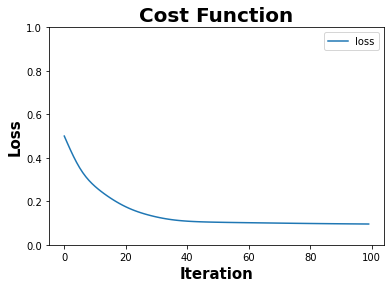

32/32 [==============================] - 0s 445us/step
TN, FP, FN, TP: 889 7 77 27
Accuracy = 0.916
Precesion = 0.7941176470588235
Recall = 0.25961538461538464
F1 = 0.391304347826087
F0.5 = 0.5625
F2 = 0.3
Gmean = 0.5075304320167185
Balanced Accu. = 0.6259014423076923
################################################## 2th CV ##################################################


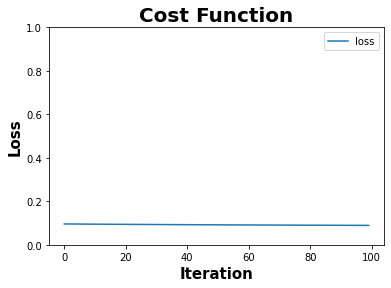

32/32 [==============================] - 0s 445us/step
TN, FP, FN, TP: 879 17 66 38
Accuracy = 0.917
Precesion = 0.6909090909090909
Recall = 0.36538461538461536
F1 = 0.4779874213836478
F0.5 = 0.5864197530864198
F2 = 0.4033970276008492
Gmean = 0.5987086894143259
Balanced Accu. = 0.6732057005494505
################################################## 3th CV ##################################################


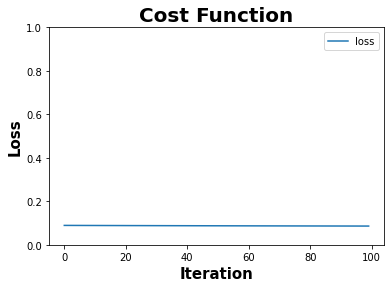

32/32 [==============================] - 0s 445us/step
TN, FP, FN, TP: 880 16 56 48
Accuracy = 0.928
Precesion = 0.75
Recall = 0.46153846153846156
F1 = 0.5714285714285714
F0.5 = 0.6666666666666666
F2 = 0.5
Gmean = 0.673273126819052
Balanced Accu. = 0.7218406593406593
################################################## 4th CV ##################################################


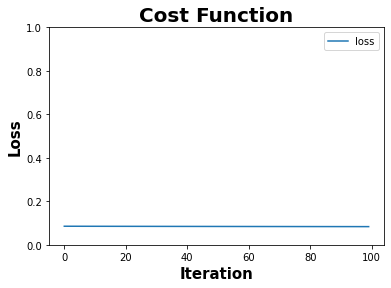

32/32 [==============================] - 0s 436us/step
TN, FP, FN, TP: 878 17 64 41
Accuracy = 0.919
Precesion = 0.7068965517241379
Recall = 0.3904761904761905
F1 = 0.5030674846625767
F0.5 = 0.6083086053412462
F2 = 0.4288702928870293
Gmean = 0.6189178655430578
Balanced Accu. = 0.6857408885341846
################################################## 5th CV ##################################################


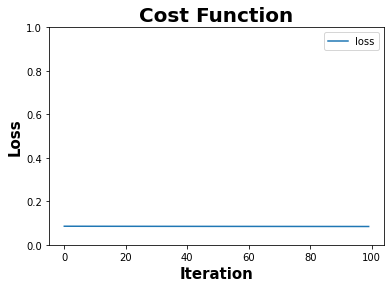

32/32 [==============================] - 0s 447us/step
TN, FP, FN, TP: 886 9 57 48
Accuracy = 0.934
Precesion = 0.8421052631578947
Recall = 0.45714285714285713
F1 = 0.5925925925925926
F0.5 = 0.7207207207207206
F2 = 0.5031446540880503
Gmean = 0.6727153111564547
Balanced Accu. = 0.7235434956105347
################################################## 6th CV ##################################################


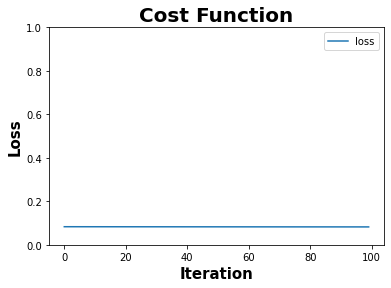

32/32 [==============================] - 0s 442us/step
TN, FP, FN, TP: 872 23 56 49
Accuracy = 0.921
Precesion = 0.6805555555555556
Recall = 0.4666666666666667
F1 = 0.5536723163841808
F0.5 = 0.6234096692111959
F2 = 0.4979674796747967
Gmean = 0.6742952731973125
Balanced Accu. = 0.7204841713221601
################################################## 7th CV ##################################################


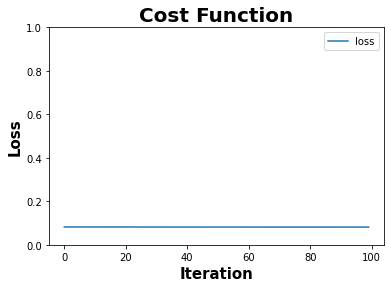

32/32 [==============================] - 0s 441us/step
TN, FP, FN, TP: 872 23 55 50
Accuracy = 0.922
Precesion = 0.684931506849315
Recall = 0.47619047619047616
F1 = 0.5617977528089888
F0.5 = 0.6297229219143576
F2 = 0.5070993914807302
Gmean = 0.6811410859997933
Balanced Accu. = 0.7252460760840649
################################################## 8th CV ##################################################


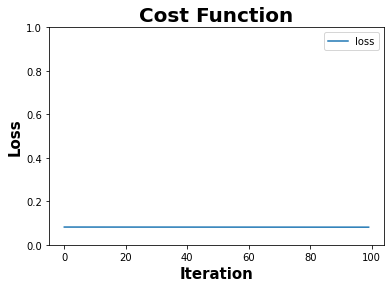

32/32 [==============================] - 0s 439us/step
TN, FP, FN, TP: 871 24 56 49
Accuracy = 0.92
Precesion = 0.6712328767123288
Recall = 0.4666666666666667
F1 = 0.550561797752809
F0.5 = 0.6171284634760705
F2 = 0.4969574036511156
Gmean = 0.6739085250879527
Balanced Accu. = 0.7199255121042831
################################################## 9th CV ##################################################


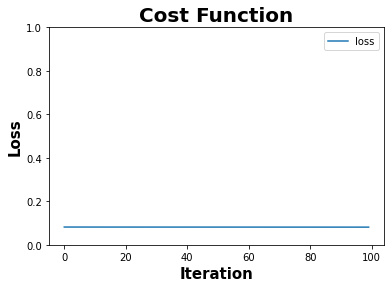

32/32 [==============================] - 0s 450us/step
TN, FP, FN, TP: 873 22 46 59
Accuracy = 0.932
Precesion = 0.7283950617283951
Recall = 0.5619047619047619
F1 = 0.6344086021505376
F0.5 = 0.6876456876456877
F2 = 0.5888223552894212
Gmean = 0.7403327480351307
Balanced Accu. = 0.7686618781590848
################################################## 10th CV ##################################################


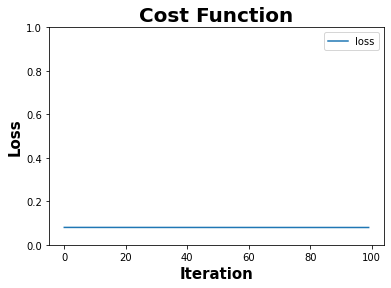

32/32 [==============================] - 0s 450us/step
TN, FP, FN, TP: 873 22 63 42
Accuracy = 0.915
Precesion = 0.65625
Recall = 0.4
F1 = 0.4970414201183432
F0.5 = 0.5817174515235457
F2 = 0.4338842975206611
Gmean = 0.6246339710305253
Balanced Accu. = 0.6877094972067039


In [19]:
acc_acc = []
acc_f1 = []
acc_f5 = []
acc_f2 = []
acc_gmean = []
acc_bacc = []

n_iter=0

###################### MLP (sigmoid // sigmoid // BCE) ############################## 
# batch_size = int(X.shape[0]*0.9)  #0.001
# print('batch_size: ', batch_size)
learning_rate=0.01

model = Sequential()
model.add(Dense(1, input_dim=X.shape[1], kernel_initializer=kernel_initializer, activation='sigmoid'))
model.summary()
opt = optimizers.Adam(learning_rate = learning_rate)   # SGD(learning_rate=learning_rate, momentum=momentum)

for train_index, test_index in skf.split(df_pca, df_pca['target']):
    n_iter += 1
    X_train = X.iloc[train_index]
    y_train= y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test= y.iloc[test_index]
    print('#'*50,'{0}th CV'.format(n_iter),'#'*50)
#     print('Labels for train:\n', label_train.value_counts())
#     print('Labels for test:\n', label_test.value_counts())
#     print(len(X_train), len(y_train), len(X_test), len(y_test))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_test = y_test.astype(float)
    
    model.compile(loss=SOL(score = 'accuracy', distribution = 'cosine', mu = 0.5, delta = 0.1, mode = 'average'), optimizer=opt)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=len(X_train))
    plt.plot(history.history['loss'], label='loss')
    plt.ylim([0, 1])
    plt.xlabel('Iteration',fontweight="bold",fontsize = 15)
    plt.ylabel('Loss',fontweight="bold",fontsize = 15)
    plt.title("Cost Function",fontweight="bold",fontsize = 20)
    plt.legend()
    plt.show()    
    predicted = np.round(model.predict(X_test))
    TN = metrics.confusion_matrix(y_test, predicted)[0,0]
    FP = metrics.confusion_matrix(y_test, predicted)[0,1]
    FN = metrics.confusion_matrix(y_test, predicted)[1,0]
    TP = metrics.confusion_matrix(y_test, predicted)[1,1]
    print("TN, FP, FN, TP:", TN, FP, FN, TP)
    print('Accuracy =', (TP+TN)/(TP+TN+FP+FN))
    print('Precesion =', TP/(TP+FP))
    print('Recall =', TP/(TP+FN))
    print('F1 =', TP / (TP + 0.5*(FP+FN)))
    print('F0.5 =', TP / (TP + 0.8*FP + 0.2*FN))
    print('F2 =', TP / (TP + 0.2*FP + 0.8*FN))
    print('Gmean =', ((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    print('Balanced Accu. =', 0.5*(TP/(TP+FN) + TN/(TN+FP)))
    acc_acc.append((TP+TN)/(TP+TN+FP+FN))
    acc_f1.append(TP / (TP + 0.5*(FP+FN)))
    acc_f5.append(TP / (TP + 0.8*FP + 0.2*FN))
    acc_f2.append(TP / (TP + 0.2*FP + 0.8*FN))
    acc_gmean.append(((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    acc_bacc.append(0.5*(TP/(TP+FN) + TN/(TN+FP)))    

In [20]:
res['AccAim'] = [np.mean(acc_acc), np.mean(acc_f1), np.mean(acc_f5), np.mean(acc_f2), np.mean(acc_gmean), np.mean(acc_bacc)]
res

,Delta,BCE,AccAim,F1Aim,F.5Aim,F2Aim,GAim,BAim
Acc,0,0,0.922400,0,0,0,0,0
F1,0,0,0.533386,0,0,0,0,0
F.5,0,0,0.628424,0,0,0,0,0
F2,0,0,0.466014,0,0,0,0,0
Gmean,0,0,0.646546,0,0,0,0,0
B_Acc,0,0,0.705226,0,0,0,0,0


batch_size:  450
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
################################################## 1th CV ##################################################


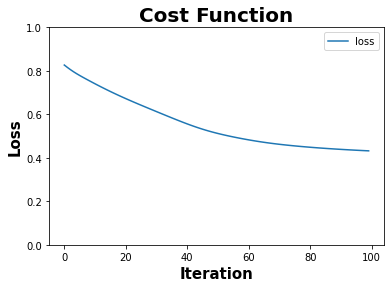

32/32 [==============================] - 0s 427us/step
TN, FP, FN, TP: 824 72 25 79
Accuracy = 0.903
Precesion = 0.5231788079470199
Recall = 0.7596153846153846
F1 = 0.6196078431372549
F0.5 = 0.557909604519774
F2 = 0.6966490299823633
Gmean = 0.8358079101308881
Balanced Accu. = 0.8396291208791209
################################################## 2th CV ##################################################


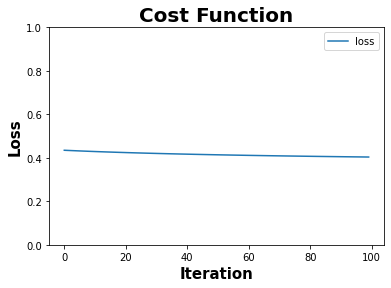

32/32 [==============================] - 0s 433us/step
TN, FP, FN, TP: 831 65 23 81
Accuracy = 0.912
Precesion = 0.5547945205479452
Recall = 0.7788461538461539
F1 = 0.648
F0.5 = 0.5886627906976745
F2 = 0.7206405693950177
Gmean = 0.8499088408616099
Balanced Accu. = 0.8531507554945055
################################################## 3th CV ##################################################


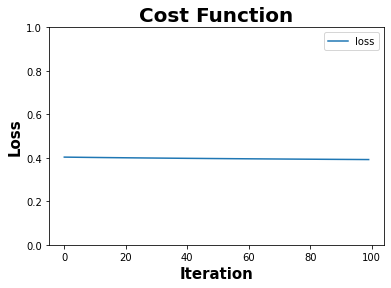

32/32 [==============================] - 0s 428us/step
TN, FP, FN, TP: 841 55 27 77
Accuracy = 0.918
Precesion = 0.5833333333333334
Recall = 0.7403846153846154
F1 = 0.652542372881356
F0.5 = 0.6091772151898734
F2 = 0.7025547445255474
Gmean = 0.8336287537258186
Balanced Accu. = 0.8395003434065934
################################################## 4th CV ##################################################


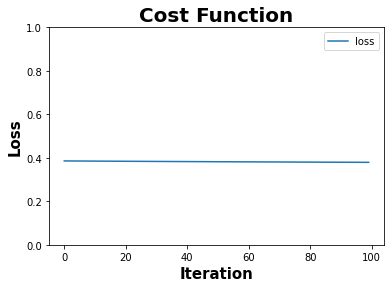

32/32 [==============================] - 0s 436us/step
TN, FP, FN, TP: 837 58 43 62
Accuracy = 0.899
Precesion = 0.5166666666666667
Recall = 0.5904761904761905
F1 = 0.5511111111111111
F0.5 = 0.5299145299145299
F2 = 0.5740740740740741
Gmean = 0.743108803832655
Balanced Accu. = 0.7628358606012238
################################################## 5th CV ##################################################


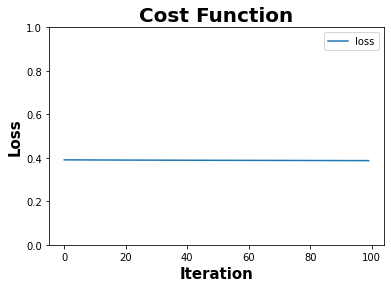

32/32 [==============================] - 0s 450us/step
TN, FP, FN, TP: 854 41 26 79
Accuracy = 0.933
Precesion = 0.6583333333333333
Recall = 0.7523809523809524
F1 = 0.7022222222222222
F0.5 = 0.6752136752136751
F2 = 0.7314814814814815
Gmean = 0.8472982585370546
Balanced Accu. = 0.8532854482575153
################################################## 6th CV ##################################################


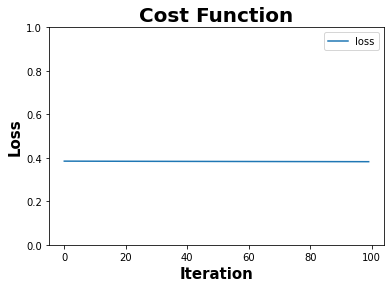

32/32 [==============================] - 0s 444us/step
TN, FP, FN, TP: 838 57 22 83
Accuracy = 0.921
Precesion = 0.5928571428571429
Recall = 0.7904761904761904
F1 = 0.6775510204081633
F0.5 = 0.6240601503759399
F2 = 0.7410714285714286
Gmean = 0.8603098361052804
Balanced Accu. = 0.8633945198191009
################################################## 7th CV ##################################################


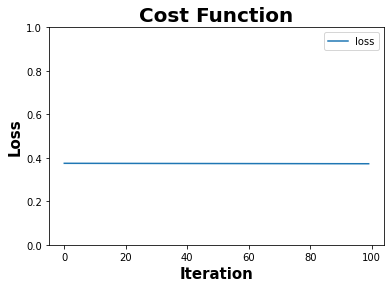

32/32 [==============================] - 0s 487us/step
TN, FP, FN, TP: 841 54 36 69
Accuracy = 0.91
Precesion = 0.5609756097560976
Recall = 0.6571428571428571
F1 = 0.6052631578947368
F0.5 = 0.5778894472361809
F2 = 0.6353591160220995
Gmean = 0.7858078736978414
Balanced Accu. = 0.7984038308060655
################################################## 8th CV ##################################################


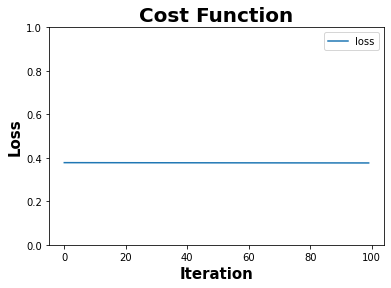

32/32 [==============================] - 0s 450us/step
TN, FP, FN, TP: 837 58 27 78
Accuracy = 0.915
Precesion = 0.5735294117647058
Recall = 0.7428571428571429
F1 = 0.6473029045643154
F0.5 = 0.6009244992295839
F2 = 0.7014388489208634
Gmean = 0.8334966586424187
Balanced Accu. = 0.8390263367916999
################################################## 9th CV ##################################################


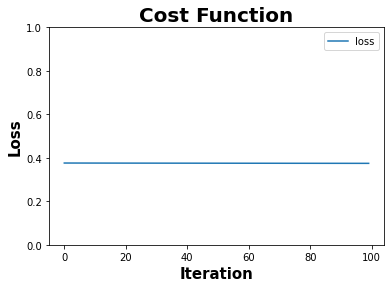

32/32 [==============================] - 0s 440us/step
TN, FP, FN, TP: 836 59 29 76
Accuracy = 0.912
Precesion = 0.562962962962963
Recall = 0.7238095238095238
F1 = 0.6333333333333333
F0.5 = 0.5891472868217055
F2 = 0.6846846846846847
Gmean = 0.8222497832403729
Balanced Accu. = 0.8289438680500133
################################################## 10th CV ##################################################


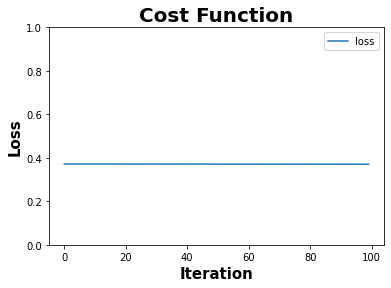

32/32 [==============================] - 0s 435us/step
TN, FP, FN, TP: 835 60 33 72
Accuracy = 0.907
Precesion = 0.5454545454545454
Recall = 0.6857142857142857
F1 = 0.6075949367088608
F0.5 = 0.5687203791469194
F2 = 0.6521739130434783
Gmean = 0.799840367153953
Balanced Accu. = 0.8093375897845172


In [245]:
f1_acc = []
f1_f1 = []
f1_f5 = []
f1_f2 = []
f1_gmean = []
f1_bacc = []
n_iter=0

###################### MLP (sigmoid // sigmoid // BCE) ############################## 
batch_size = int(X.shape[0]*0.9 * 0.05) 
print('batch_size: ', batch_size)
learning_rate=0.005

model = Sequential()
model.add(Dense(1, input_dim=X.shape[1], kernel_initializer=kernel_initializer, activation='sigmoid'))
model.summary()
opt = optimizers.Adam(learning_rate = learning_rate)   # SGD(learning_rate=learning_rate, momentum=momentum)

for train_index, test_index in skf.split(df_pca, df_pca['target']):
    n_iter += 1
    X_train = X.iloc[train_index]
    y_train= y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test= y.iloc[test_index]
    print('#'*50,'{0}th CV'.format(n_iter),'#'*50)
#     print('Labels for train:\n', label_train.value_counts())
#     print('Labels for test:\n', label_test.value_counts())
#     print(len(X_train), len(y_train), len(X_test), len(y_test))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_test = y_test.astype(float)
    
    model.compile(loss=SOL(score = 'f1_score', distribution = 'cosine', mu = 0.5, delta = 0.1, mode = 'average'), optimizer=opt)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=len(X_train))
    plt.plot(history.history['loss'], label='loss')
    plt.ylim([0, 1])
    plt.xlabel('Iteration',fontweight="bold",fontsize = 15)
    plt.ylabel('Loss',fontweight="bold",fontsize = 15)
    plt.title("Cost Function",fontweight="bold",fontsize = 20)
    plt.legend()
    plt.show()    
    predicted = np.round(model.predict(X_test))
    TN = metrics.confusion_matrix(y_test, predicted)[0,0]
    FP = metrics.confusion_matrix(y_test, predicted)[0,1]
    FN = metrics.confusion_matrix(y_test, predicted)[1,0]
    TP = metrics.confusion_matrix(y_test, predicted)[1,1]
    print("TN, FP, FN, TP:", TN, FP, FN, TP)
    print('Accuracy =', (TP+TN)/(TP+TN+FP+FN))
    print('Precesion =', TP/(TP+FP))
    print('Recall =', TP/(TP+FN))
    print('F1 =', TP / (TP + 0.5*(FP+FN)))
    print('F0.5 =', TP / (TP + 0.8*FP + 0.2*FN))
    print('F2 =', TP / (TP + 0.2*FP + 0.8*FN))
    print('Gmean =', ((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    print('Balanced Accu. =', 0.5*(TP/(TP+FN) + TN/(TN+FP)))
    f1_acc.append((TP+TN)/(TP+TN+FP+FN))
    f1_f1.append(TP / (TP + 0.5*(FP+FN)))
    f1_f5.append(TP / (TP + 0.8*FP + 0.2*FN))
    f1_f2.append(TP / (TP + 0.2*FP + 0.8*FN))
    f1_gmean.append(((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    f1_bacc.append(0.5*(TP/(TP+FN) + TN/(TN+FP)))    

In [246]:
res['F1Aim'] = [np.mean(f1_acc), np.mean(f1_f1), np.mean(f1_f5), np.mean(f1_f2), np.mean(f1_gmean), np.mean(f1_bacc)]
res

,Delta,BCE,AccAim,F1Aim,F.5Aim,F2Aim,GAim,BAim
Acc,0,0,0.922400,0.913000,0,0,0,0.844400
F1,0,0,0.533386,0.634453,0,0,0,0.547365
F.5,0,0,0.628424,0.592162,0,0,0,0.443573
F2,0,0,0.466014,0.684013,0,0,0,0.714676
Gmean,0,0,0.646546,0.821146,0,0,0,0.867368
B_Acc,0,0,0.705226,0.828751,0,0,0,0.867965


batch_size:  4500
Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
################################################## 1th CV ##################################################


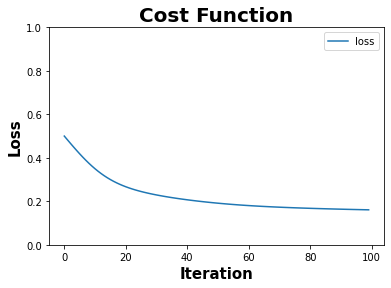

32/32 [==============================] - 0s 423us/step
TN, FP, FN, TP: 749 147 15 89
Accuracy = 0.838
Precesion = 0.3771186440677966
Recall = 0.8557692307692307
F1 = 0.5235294117647059
F0.5 = 0.424618320610687
F2 = 0.6825153374233128
Gmean = 0.8457952419741753
Balanced Accu. = 0.8458533653846154
################################################## 2th CV ##################################################


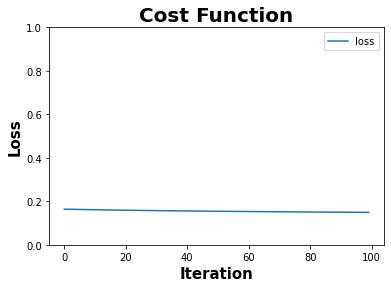

32/32 [==============================] - 0s 424us/step
TN, FP, FN, TP: 752 144 8 96
Accuracy = 0.848
Precesion = 0.4
Recall = 0.9230769230769231
F1 = 0.5581395348837209
F0.5 = 0.4511278195488722
F2 = 0.7317073170731708
Gmean = 0.8801847957817011
Balanced Accu. = 0.8811813186813187
################################################## 3th CV ##################################################


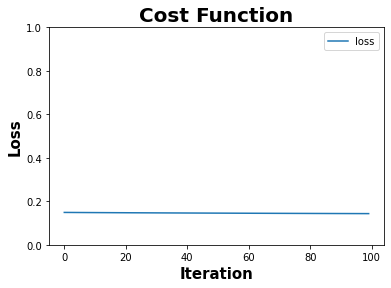

32/32 [==============================] - 0s 423us/step
TN, FP, FN, TP: 769 127 7 97
Accuracy = 0.866
Precesion = 0.4330357142857143
Recall = 0.9326923076923077
F1 = 0.5914634146341463
F0.5 = 0.48499999999999993
F2 = 0.7578125
Gmean = 0.8947019060484968
Balanced Accu. = 0.8954756181318682
################################################## 4th CV ##################################################


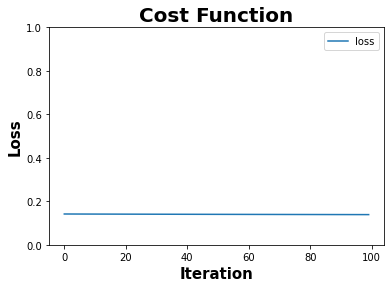

32/32 [==============================] - 0s 426us/step
TN, FP, FN, TP: 759 136 9 96
Accuracy = 0.855
Precesion = 0.41379310344827586
Recall = 0.9142857142857143
F1 = 0.56973293768546
F0.5 = 0.4646660212971926
F2 = 0.7361963190184049
Gmean = 0.8805425302878053
Balanced Accu. = 0.8811652035115722
################################################## 5th CV ##################################################


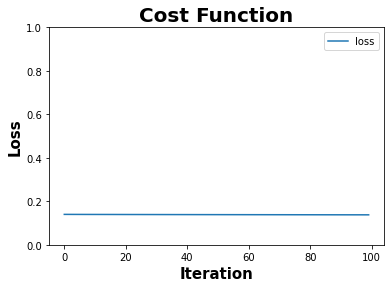

32/32 [==============================] - 0s 416us/step
TN, FP, FN, TP: 759 136 8 97
Accuracy = 0.856
Precesion = 0.41630901287553645
Recall = 0.9238095238095239
F1 = 0.5739644970414202
F0.5 = 0.46769527483124396
F2 = 0.7427258805513017
Gmean = 0.8851168079790144
Balanced Accu. = 0.885927108273477
################################################## 6th CV ##################################################


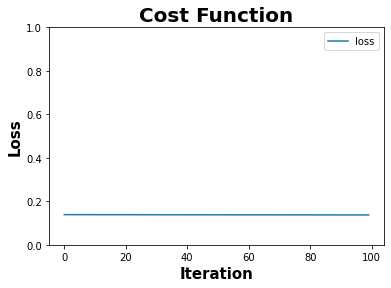

32/32 [==============================] - 0s 419us/step
TN, FP, FN, TP: 757 138 7 98
Accuracy = 0.855
Precesion = 0.4152542372881356
Recall = 0.9333333333333333
F1 = 0.5747800586510264
F0.5 = 0.46711153479504286
F2 = 0.7469512195121952
Gmean = 0.888494636341826
Balanced Accu. = 0.8895716945996276
################################################## 7th CV ##################################################


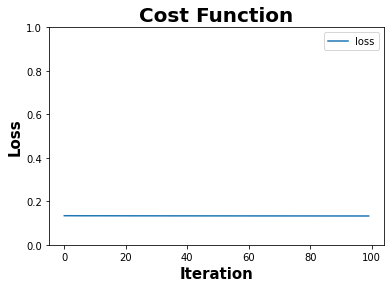

32/32 [==============================] - 0s 418us/step
TN, FP, FN, TP: 761 134 12 93
Accuracy = 0.854
Precesion = 0.40969162995594716
Recall = 0.8857142857142857
F1 = 0.5602409638554217
F0.5 = 0.45903257650542945
F2 = 0.7187017001545595
Gmean = 0.8678159649846289
Balanced Accu. = 0.8679968076616121
################################################## 8th CV ##################################################


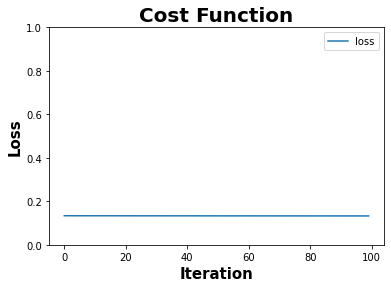

32/32 [==============================] - 0s 426us/step
TN, FP, FN, TP: 757 138 12 93
Accuracy = 0.85
Precesion = 0.4025974025974026
Recall = 0.8857142857142857
F1 = 0.5535714285714286
F0.5 = 0.4518950437317784
F2 = 0.7142857142857143
Gmean = 0.8655322348019426
Balanced Accu. = 0.8657621707901038
################################################## 9th CV ##################################################


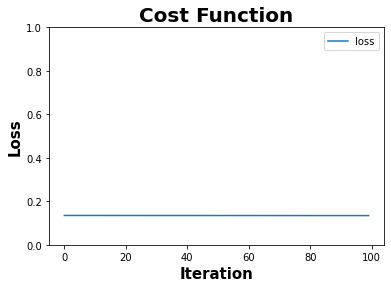

32/32 [==============================] - 0s 412us/step
TN, FP, FN, TP: 769 126 9 96
Accuracy = 0.865
Precesion = 0.43243243243243246
Recall = 0.9142857142857143
F1 = 0.5871559633027523
F0.5 = 0.4833836858006042
F2 = 0.7476635514018691
Gmean = 0.8863242242468788
Balanced Accu. = 0.8867517956903432
################################################## 10th CV ##################################################


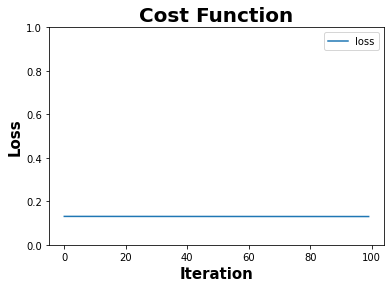

32/32 [==============================] - 0s 425us/step
TN, FP, FN, TP: 757 138 16 89
Accuracy = 0.846
Precesion = 0.3920704845814978
Recall = 0.8476190476190476
F1 = 0.536144578313253
F0.5 = 0.43928923988154
F2 = 0.6877897990726429
Gmean = 0.8467140686321954
Balanced Accu. = 0.8467145517424848


In [247]:
bacc_acc = []
bacc_f1 = []
bacc_f5 = []
bacc_f2 = []
bacc_gmean = []
bacc_bacc = []

n_iter=0

###################### MLP (sigmoid // sigmoid // BCE) ############################## 
batch_size = int(X.shape[0]*0.9 * 0.5) 
print('batch_size: ', batch_size)
learning_rate=0.005

model = Sequential()
model.add(Dense(1, input_dim=X.shape[1], kernel_initializer=kernel_initializer, activation='sigmoid'))
model.summary()
opt = optimizers.Adam(learning_rate = learning_rate)   # SGD(learning_rate=learning_rate, momentum=momentum)

for train_index, test_index in skf.split(df_pca, df_pca['target']):
    n_iter += 1
    X_train = X.iloc[train_index]
    y_train= y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test= y.iloc[test_index]
    print('#'*50,'{0}th CV'.format(n_iter),'#'*50)
#     print('Labels for train:\n', label_train.value_counts())
#     print('Labels for test:\n', label_test.value_counts())
#     print(len(X_train), len(y_train), len(X_test), len(y_test))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_test = y_test.astype(float)
    
    model.compile(loss=SOL(score = 'bacc', distribution = 'cosine', mu = 0.5, delta = 0.1, mode = 'average'), optimizer=opt)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=len(X_train))
    plt.plot(history.history['loss'], label='loss')
    plt.ylim([0, 1])
    plt.xlabel('Iteration',fontweight="bold",fontsize = 15)
    plt.ylabel('Loss',fontweight="bold",fontsize = 15)
    plt.title("Cost Function",fontweight="bold",fontsize = 20)
    plt.legend()
    plt.show()    
    predicted = np.round(model.predict(X_test))
    TN = metrics.confusion_matrix(y_test, predicted)[0,0]
    FP = metrics.confusion_matrix(y_test, predicted)[0,1]
    FN = metrics.confusion_matrix(y_test, predicted)[1,0]
    TP = metrics.confusion_matrix(y_test, predicted)[1,1]
    print("TN, FP, FN, TP:", TN, FP, FN, TP)
    print('Accuracy =', (TP+TN)/(TP+TN+FP+FN))
    print('Precesion =', TP/(TP+FP))
    print('Recall =', TP/(TP+FN))
    print('F1 =', TP / (TP + 0.5*(FP+FN)))
    print('F0.5 =', TP / (TP + 0.8*FP + 0.2*FN))
    print('F2 =', TP / (TP + 0.2*FP + 0.8*FN))
    print('Gmean =', ((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    print('Balanced Accu. =', 0.5*(TP/(TP+FN) + TN/(TN+FP)))
    bacc_acc.append((TP+TN)/(TP+TN+FP+FN))
    bacc_f1.append(TP / (TP + 0.5*(FP+FN)))
    bacc_f5.append(TP / (TP + 0.8*FP + 0.2*FN))
    bacc_f2.append(TP / (TP + 0.2*FP + 0.8*FN))
    bacc_gmean.append(((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    bacc_bacc.append(0.5*(TP/(TP+FN) + TN/(TN+FP)))    

In [248]:
res['BAim'] = [np.mean(bacc_acc), np.mean(bacc_f1), np.mean(bacc_f5), np.mean(bacc_f2), np.mean(bacc_gmean), np.mean(bacc_bacc)]
res

,Delta,BCE,AccAim,F1Aim,F.5Aim,F2Aim,GAim,BAim
Acc,0,0,0.922400,0.913000,0,0,0,0.853300
F1,0,0,0.533386,0.634453,0,0,0,0.562872
F.5,0,0,0.628424,0.592162,0,0,0,0.459382
F2,0,0,0.466014,0.684013,0,0,0,0.726635
Gmean,0,0,0.646546,0.821146,0,0,0,0.874122
B_Acc,0,0,0.705226,0.828751,0,0,0,0.874640


# 2. Creditcard Fraud Detection 2023(29d / 298531)

In [249]:
# class '0' = normal, class '1' = anomaly
card_df = pd.read_csv('creditcard_2023.csv')
card_df.shape

(568630, 31)

In [250]:
# 결측치 확인
card_df.isnull().sum()

id        0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [251]:
card_df.head()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


In [252]:
card_df.describe()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,568630.000000,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,...,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,568630.000000,568630.0
mean,284314.500000,-5.638058e-17,-1.319545e-16,-3.518788e-17,-2.879008e-17,7.997245e-18,-3.958636e-17,-3.198898e-17,2.109273e-17,3.998623e-17,...,4.758361e-17,3.948640e-18,6.194741e-18,-2.799036e-18,-3.178905e-17,-7.497417e-18,-3.598760e-17,2.609101e-17,12041.957635,0.5
std,164149.486122,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,6919.644449,0.5
min,0.000000,-3.495584e+00,-4.996657e+01,-3.183760e+00,-4.951222e+00,-9.952786e+00,-2.111111e+01,-4.351839e+00,-1.075634e+01,-3.751919e+00,...,-1.938252e+01,-7.734798e+00,-3.029545e+01,-4.067968e+00,-1.361263e+01,-8.226969e+00,-1.049863e+01,-3.903524e+01,50.010000,0.0
25%,142157.250000,-5.652859e-01,-4.866777e-01,-6.492987e-01,-6.560203e-01,-2.934955e-01,-4.458712e-01,-2.835329e-01,-1.922572e-01,-5.687446e-01,...,-1.664408e-01,-4.904892e-01,-2.376289e-01,-6.515801e-01,-5.541485e-01,-6.318948e-01,-3.049607e-01,-2.318783e-01,6054.892500,0.0
50%,284314.500000,-9.363846e-02,-1.358939e-01,3.528579e-04,-7.376152e-02,8.108788e-02,7.871758e-02,2.333659e-01,-1.145242e-01,9.252647e-02,...,-3.743065e-02,-2.732881e-02,-5.968903e-02,1.590123e-02,-8.193162e-03,-1.189208e-02,-1.729111e-01,-1.392973e-02,12030.150000,0.5
75%,426471.750000,8.326582e-01,3.435552e-01,6.285380e-01,7.070047e-01,4.397368e-01,4.977881e-01,5.259548e-01,4.729905e-02,5.592621e-01,...,1.479787e-01,4.638817e-01,1.557153e-01,7.007374e-01,5.500147e-01,6.728879e-01,3.340230e-01,4.095903e-01,18036.330000,1.0
max,568629.000000,2.229046e+00,4.361865e+00,1.412583e+01,3.201536e+00,4.271689e+01,2.616840e+01,2.178730e+02,5.958040e+00,2.027006e+01,...,8.087080e+00,1.263251e+01,3.170763e+01,1.296564e+01,1.462151e+01,5.623285e+00,1.132311e+02,7.725594e+01,24039.930000,1.0


In [253]:
# Amount values largely varies.

# # Normalization
# card_df.iloc[:,:-1] = (card_df.iloc[:,:-1] - card_df.iloc[:,:-1].min())/(card_df.iloc[:,:-1].max() - card_df.iloc[:,:-1].min())

# Standardization
card_df.iloc[:,:-1] = (card_df.iloc[:,:-1] - card_df.iloc[:,:-1].mean())/card_df.iloc[:,:-1].std()

card_df

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.732046,-0.260648,-0.469648,2.496264,-0.083724,0.129681,0.732898,0.519013,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,0.858446,0
1,-1.732040,0.985099,-0.356045,0.558056,-0.429654,0.277140,0.428604,0.406466,-0.133118,0.347452,...,-0.194936,-0.605760,0.079469,-0.577394,0.190090,0.296502,-0.248052,-0.064512,-0.796369,0
2,-1.732034,-0.260271,-0.949384,1.728536,-0.457986,0.074062,1.419480,0.743510,-0.095576,-0.261296,...,-0.005020,0.702906,0.945045,-1.154665,-0.605563,-0.312894,-0.300258,-0.244718,-1.377010,0
3,-1.732028,-0.152152,-0.508958,1.746839,-1.090177,0.249486,1.143311,0.518268,-0.065130,-0.205697,...,-0.146927,-0.038212,-0.214048,-1.893129,1.003962,-0.515950,-0.165316,0.048424,-0.962118,0
4,-1.732022,-0.206819,-0.165280,1.527051,-0.448292,0.106125,0.530548,0.658849,-0.212660,1.049920,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071125,0.023712,0.419117,0.323284,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568625,1.732022,-0.833437,0.061886,-0.899793,0.904226,-1.002400,0.481453,-0.370393,0.189693,-0.938152,...,0.167503,0.419731,1.288248,-0.900860,0.560661,-0.006018,3.308965,0.081564,-1.105230,1
568626,1.732028,-0.670459,-0.202896,-0.068129,-0.267328,-0.133660,0.237148,-0.016935,-0.147733,0.483893,...,0.031874,0.388161,-0.154257,-0.846451,-0.153443,1.961396,-1.528640,1.704305,-1.067766,1
568627,1.732034,-0.311997,-0.004095,0.137525,-0.035893,-0.042291,0.121098,-0.070958,-0.019997,-0.122048,...,0.140787,0.536522,-0.211100,-0.448908,0.540073,-0.755835,-0.487539,-0.268741,1.666400,1
568628,1.732040,0.636870,-0.516969,-0.300888,-0.144480,0.131042,-0.294148,0.580568,-0.207723,0.893526,...,-0.060380,-0.195609,-0.175487,-0.554643,-0.099669,-1.434930,-0.159269,-0.076251,-0.271853,1


In [254]:
card_df['Class'].value_counts()

0    284315
1    284315
Name: Class, dtype: int64

In [255]:
# Data is too balanced!!! We intentionally make it imbalanced.
df_0 = card_df[card_df['Class']==0]
df_1 = card_df[card_df['Class']==1]
print(len(df_0), len(df_1))

284315 284315


In [256]:
N = round(len(df_0)*0.05)
df_1_samp = df_1.sample(n=N, random_state = 100)
df_1_samp

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
506274,1.352179,-0.006870,-0.167584,-0.426402,0.286979,3.061201,-1.574602,0.044742,-0.428210,0.154000,...,-0.386374,-0.470302,-1.743519,-1.185101,-1.558751,-1.397993,-0.012629,0.450646,1.114237,1
387527,0.628771,-1.505330,0.343708,-1.307073,1.727683,-0.524436,-2.021618,-2.304781,-0.078004,-1.148383,...,-0.427704,-1.212065,-12.554995,0.951595,-5.763942,0.191730,3.949965,-1.475321,-0.071128,1
365951,0.497330,-0.503065,0.153162,-0.422713,-0.354370,-0.419048,-0.107715,0.314880,-0.203583,0.279555,...,0.037084,-0.209385,0.549983,0.396777,-1.430279,-2.486924,-0.617871,0.560011,-1.321357,1
525848,1.471424,-1.021538,-1.187974,-0.746483,-0.029644,0.009252,-0.507414,0.471536,-0.015704,-0.207999,...,0.018479,0.766577,0.123668,0.268437,0.800809,0.413684,-0.034178,-0.097596,1.445303,1
481288,1.199964,-0.509792,0.194382,-0.386280,-0.611187,0.135320,0.440036,-0.240672,-0.615084,0.251804,...,-0.095779,0.402399,-0.251087,-0.566821,0.409498,-1.473372,-0.251349,-0.044765,-0.010947,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491209,1.260403,-1.088031,0.682312,-0.917454,0.643955,-0.652642,-0.555339,-0.667876,0.288458,-0.764149,...,0.528281,0.386071,0.095967,1.123651,-0.015030,0.636864,-1.803348,1.164825,-0.080206,1
372018,0.534290,-2.281503,2.701140,-2.214454,1.222394,-2.728423,-2.561828,-2.136703,4.308934,-1.151728,...,0.558177,-1.432524,-0.994643,0.310707,2.660860,-0.516013,1.909650,0.968061,0.731649,1
343903,0.363014,-0.267325,0.352643,-0.836113,0.475835,-0.673489,-0.723249,-0.492036,0.200382,-0.714633,...,0.283521,0.720715,0.230679,0.010768,-0.039101,1.150750,0.024092,-0.461128,0.646750,1
452083,1.022047,-2.174120,2.531664,-2.126482,1.202406,-2.566989,-2.477827,-2.045211,3.892891,-1.178189,...,0.554093,-1.297113,-0.862695,0.284146,2.371527,-0.520116,2.028946,1.024555,0.740116,1


In [257]:
df_card = concath(df_0, df_1_samp)
df_card

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.732046,-0.260648,-0.469648,2.496264,-0.083724,0.129681,0.732898,0.519013,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,0.858446,0
1,-1.732040,0.985099,-0.356045,0.558056,-0.429654,0.277140,0.428604,0.406466,-0.133118,0.347452,...,-0.194936,-0.605760,0.079469,-0.577394,0.190090,0.296502,-0.248052,-0.064512,-0.796369,0
2,-1.732034,-0.260271,-0.949384,1.728536,-0.457986,0.074062,1.419480,0.743510,-0.095576,-0.261296,...,-0.005020,0.702906,0.945045,-1.154665,-0.605563,-0.312894,-0.300258,-0.244718,-1.377010,0
3,-1.732028,-0.152152,-0.508958,1.746839,-1.090177,0.249486,1.143311,0.518268,-0.065130,-0.205697,...,-0.146927,-0.038212,-0.214048,-1.893129,1.003962,-0.515950,-0.165316,0.048424,-0.962118,0
4,-1.732022,-0.206819,-0.165280,1.527051,-0.448292,0.106125,0.530548,0.658849,-0.212660,1.049920,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071125,0.023712,0.419117,0.323284,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491209,1.260403,-1.088031,0.682312,-0.917454,0.643955,-0.652642,-0.555339,-0.667876,0.288458,-0.764149,...,0.528281,0.386071,0.095967,1.123651,-0.015030,0.636864,-1.803348,1.164825,-0.080206,1
372018,0.534290,-2.281503,2.701140,-2.214454,1.222394,-2.728423,-2.561828,-2.136703,4.308934,-1.151728,...,0.558177,-1.432524,-0.994643,0.310707,2.660860,-0.516013,1.909650,0.968061,0.731649,1
343903,0.363014,-0.267325,0.352643,-0.836113,0.475835,-0.673489,-0.723249,-0.492036,0.200382,-0.714633,...,0.283521,0.720715,0.230679,0.010768,-0.039101,1.150750,0.024092,-0.461128,0.646750,1
452083,1.022047,-2.174120,2.531664,-2.126482,1.202406,-2.566989,-2.477827,-2.045211,3.892891,-1.178189,...,0.554093,-1.297113,-0.862695,0.284146,2.371527,-0.520116,2.028946,1.024555,0.740116,1


In [258]:
df_card.columns

Index(['id', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [259]:
df_card = df_card.drop('id', axis=1)
df_card

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.260648,-0.469648,2.496264,-0.083724,0.129681,0.732898,0.519013,-0.130006,0.727159,0.637734,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,0.858446,0
1,0.985099,-0.356045,0.558056,-0.429654,0.277140,0.428604,0.406466,-0.133118,0.347452,0.529808,...,-0.194936,-0.605760,0.079469,-0.577394,0.190090,0.296502,-0.248052,-0.064512,-0.796369,0
2,-0.260271,-0.949384,1.728536,-0.457986,0.074062,1.419480,0.743510,-0.095576,-0.261296,0.690707,...,-0.005020,0.702906,0.945045,-1.154665,-0.605563,-0.312894,-0.300258,-0.244718,-1.377010,0
3,-0.152152,-0.508958,1.746839,-1.090177,0.249486,1.143311,0.518268,-0.065130,-0.205697,0.575230,...,-0.146927,-0.038212,-0.214048,-1.893129,1.003962,-0.515950,-0.165316,0.048424,-0.962118,0
4,-0.206819,-0.165280,1.527051,-0.448292,0.106125,0.530548,0.658849,-0.212660,1.049920,0.968045,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071125,0.023712,0.419117,0.323284,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491209,-1.088031,0.682312,-0.917454,0.643955,-0.652642,-0.555339,-0.667876,0.288458,-0.764149,-0.665831,...,0.528281,0.386071,0.095967,1.123651,-0.015030,0.636864,-1.803348,1.164825,-0.080206,1
372018,-2.281503,2.701140,-2.214454,1.222394,-2.728423,-2.561828,-2.136703,4.308934,-1.151728,-1.283930,...,0.558177,-1.432524,-0.994643,0.310707,2.660860,-0.516013,1.909650,0.968061,0.731649,1
343903,-0.267325,0.352643,-0.836113,0.475835,-0.673489,-0.723249,-0.492036,0.200382,-0.714633,-0.660779,...,0.283521,0.720715,0.230679,0.010768,-0.039101,1.150750,0.024092,-0.461128,0.646750,1
452083,-2.174120,2.531664,-2.126482,1.202406,-2.566989,-2.477827,-2.045211,3.892891,-1.178189,-1.315622,...,0.554093,-1.297113,-0.862695,0.284146,2.371527,-0.520116,2.028946,1.024555,0.740116,1


In [260]:
res = pd.DataFrame({'Delta':[0, 0, 0, 0, 0, 0],
                    'BCE':[0, 0, 0, 0, 0, 0],
                    'AccAim':[0, 0, 0, 0, 0, 0],
                    'F1Aim':[0, 0, 0, 0, 0, 0],
                    'F.5Aim':[0, 0, 0, 0, 0, 0],
                    'F2Aim':[0, 0, 0, 0, 0, 0],
                    'GAim':[0, 0, 0, 0, 0, 0],
                    'BAim':[0, 0, 0, 0, 0, 0]}, index = ['Acc','F1','F.5','F2','Gmean','B_Acc'])

In [261]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state = 2)

X = df_card.iloc[:, :-1]
y = df_card.iloc[:, -1]

In [262]:
L = 73
hidden_node = 2
# momentum=0.9
activation = 'sigmoid'  
kernel_initializer=keras.initializers.Zeros
epochs=100

batch_size:  13433
Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_58 (Dense)            (None, 1)                 30        
                                                                 
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
################################################## 1th CV ##################################################


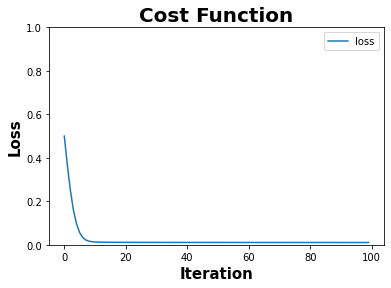

933/933 [==============================] - 0s 391us/step
TN, FP, FN, TP: 28429 3 293 1129
Accuracy = 0.9900850807262008
Precesion = 0.9973498233215548
Recall = 0.7939521800281294
F1 = 0.8841033672670321
F0.5 = 0.9487394957983193
F2 = 0.8277126099706745
Gmean = 0.8909929327627165
Balanced Accu. = 0.8969233325576775
################################################## 2th CV ##################################################


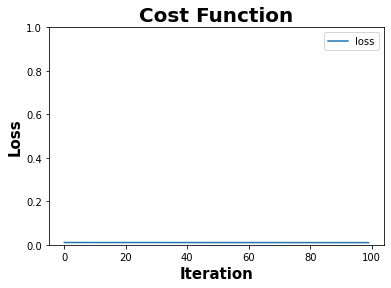

933/933 [==============================] - 0s 400us/step
TN, FP, FN, TP: 28425 7 290 1131
Accuracy = 0.9900512511305396
Precesion = 0.9938488576449912
Recall = 0.7959183673469388
F1 = 0.8839390386869871
F0.5 = 0.9467604218985435
F2 = 0.8289357959542656
Gmean = 0.8920327410360888
Balanced Accu. = 0.8978360829418993
################################################## 3th CV ##################################################


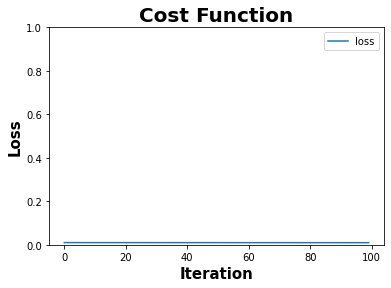

933/933 [==============================] - 0s 391us/step
TN, FP, FN, TP: 28423 9 274 1147
Accuracy = 0.9905202157237128
Precesion = 0.9922145328719724
Recall = 0.8071780436312456
F1 = 0.8901823826154444
F0.5 = 0.9487179487179487
F2 = 0.8384502923976608
Gmean = 0.8982886705667863
Balanced Accu. = 0.9034307494464613
################################################## 4th CV ##################################################


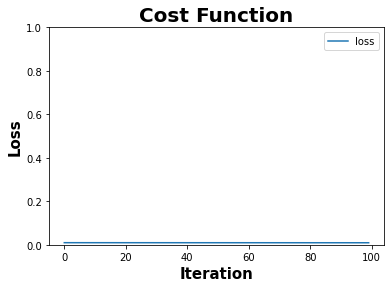

933/933 [==============================] - 0s 392us/step
TN, FP, FN, TP: 28425 7 272 1149
Accuracy = 0.9906542056074766
Precesion = 0.9939446366782007
Recall = 0.8085855031667839
F1 = 0.8917345750873108
F0.5 = 0.9503722084367245
F2 = 0.8399122807017544
Gmean = 0.8991031243593975
Balanced Accu. = 0.9041696508518219
################################################## 5th CV ##################################################


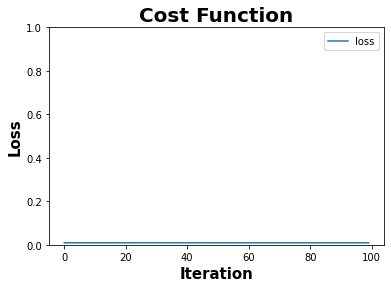

933/933 [==============================] - 0s 411us/step
TN, FP, FN, TP: 28423 9 278 1143
Accuracy = 0.9903862258399491
Precesion = 0.9921875
Recall = 0.8043631245601689
F1 = 0.8884570540225418
F0.5 = 0.9479183944269365
F2 = 0.8360152135751902
Gmean = 0.8967209753570997
Balanced Accu. = 0.902023289910923
################################################## 6th CV ##################################################


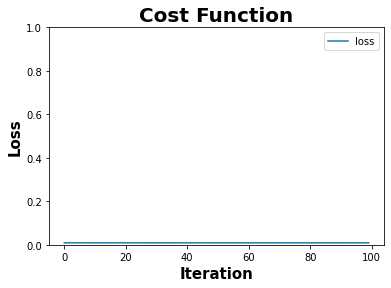

933/933 [==============================] - 0s 404us/step
TN, FP, FN, TP: 28418 13 268 1154
Accuracy = 0.9905872106655947
Precesion = 0.988860325621251
Recall = 0.8115330520393812
F1 = 0.8914638856701429
F0.5 = 0.9474548440065681
F2 = 0.8417213712618526
Gmean = 0.9006453134752862
Balanced Accu. = 0.9055379023342768
################################################## 7th CV ##################################################


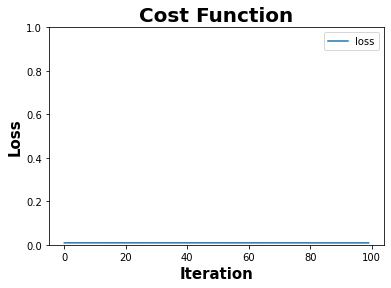

933/933 [==============================] - 0s 397us/step
TN, FP, FN, TP: 28424 7 255 1167
Accuracy = 0.9912236626134727
Precesion = 0.9940374787052811
Recall = 0.820675105485232
F1 = 0.899075500770416
F0.5 = 0.9537430532853874
F2 = 0.8503351792480326
Gmean = 0.9057996726466453
Balanced Accu. = 0.9102144476812393
################################################## 8th CV ##################################################


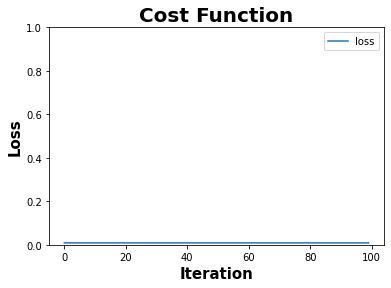

933/933 [==============================] - 0s 402us/step
TN, FP, FN, TP: 28418 13 248 1174
Accuracy = 0.9912571600844137
Precesion = 0.9890480202190396
Recall = 0.8255977496483825
F1 = 0.8999616711383672
F0.5 = 0.9513776337115073
F2 = 0.8538181818181818
Gmean = 0.908416340258141
Balanced Accu. = 0.9125702511387774
################################################## 9th CV ##################################################


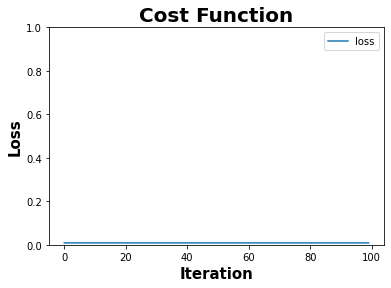

933/933 [==============================] - 0s 404us/step
TN, FP, FN, TP: 28427 4 236 1186
Accuracy = 0.9919606069741734
Precesion = 0.9966386554621849
Recall = 0.8340365682137834
F1 = 0.9081163859111792
F0.5 = 0.9592364930443221
F2 = 0.8621692352428032
Gmean = 0.9131917796164272
Balanced Accu. = 0.9169479383575336
################################################## 10th CV ##################################################


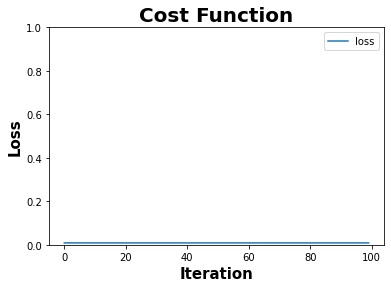

933/933 [==============================] - 0s 398us/step
TN, FP, FN, TP: 28427 4 247 1175
Accuracy = 0.991592134793823
Precesion = 0.996607294317218
Recall = 0.8263009845288326
F1 = 0.9034986543637062
F0.5 = 0.957152166829586
F2 = 0.855540993155672
Gmean = 0.9089470452149171
Balanced Accu. = 0.9130801465150582


In [263]:
acc_acc = []
acc_f1 = []
acc_f5 = []
acc_f2 = []
acc_gmean = []
acc_bacc = []

n_iter=0

###################### MLP (sigmoid // sigmoid // BCE) ############################## 
batch_size = int(X.shape[0]*0.9 * 0.05)  
print('batch_size: ', batch_size)
learning_rate=0.005

model = Sequential()
model.add(Dense(1, input_dim=X.shape[1], kernel_initializer=kernel_initializer, activation='sigmoid'))
model.summary()
opt = optimizers.Adam(learning_rate = learning_rate)   # SGD(learning_rate=learning_rate, momentum=momentum)

for train_index, test_index in skf.split(df_card, df_card.iloc[:, -1]):
    n_iter += 1
    X_train = X.iloc[train_index]
    y_train= y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test= y.iloc[test_index]
    print('#'*50,'{0}th CV'.format(n_iter),'#'*50)
#     print('Labels for train:\n', label_train.value_counts())
#     print('Labels for test:\n', label_test.value_counts())
#     print(len(X_train), len(y_train), len(X_test), len(y_test))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_test = y_test.astype(float)
    
    model.compile(loss=SOL(score = 'accuracy', distribution = 'cosine', mu = 0.5, delta = 0.1, mode = 'average'), optimizer=opt)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=len(X_train))
    plt.plot(history.history['loss'], label='loss')
    plt.ylim([0, 1])
    plt.xlabel('Iteration',fontweight="bold",fontsize = 15)
    plt.ylabel('Loss',fontweight="bold",fontsize = 15)
    plt.title("Cost Function",fontweight="bold",fontsize = 20)
    plt.legend()
    plt.show()    
    predicted = np.round(model.predict(X_test))
    TN = metrics.confusion_matrix(y_test, predicted)[0,0]
    FP = metrics.confusion_matrix(y_test, predicted)[0,1]
    FN = metrics.confusion_matrix(y_test, predicted)[1,0]
    TP = metrics.confusion_matrix(y_test, predicted)[1,1]
    print("TN, FP, FN, TP:", TN, FP, FN, TP)
    print('Accuracy =', (TP+TN)/(TP+TN+FP+FN))
    print('Precesion =', TP/(TP+FP))
    print('Recall =', TP/(TP+FN))
    print('F1 =', TP / (TP + 0.5*(FP+FN)))
    print('F0.5 =', TP / (TP + 0.8*FP + 0.2*FN))
    print('F2 =', TP / (TP + 0.2*FP + 0.8*FN))
    print('Gmean =', ((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    print('Balanced Accu. =', 0.5*(TP/(TP+FN) + TN/(TN+FP)))
    acc_acc.append((TP+TN)/(TP+TN+FP+FN))
    acc_f1.append(TP / (TP + 0.5*(FP+FN)))
    acc_f5.append(TP / (TP + 0.8*FP + 0.2*FN))
    acc_f2.append(TP / (TP + 0.2*FP + 0.8*FN))
    acc_gmean.append(((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    acc_bacc.append(0.5*(TP/(TP+FN) + TN/(TN+FP)))    

In [264]:
res['AccAim'] = [np.mean(acc_acc), np.mean(acc_f1), np.mean(acc_f5), np.mean(acc_f2), np.mean(acc_gmean), np.mean(acc_bacc)]
res

,Delta,BCE,AccAim,F1Aim,F.5Aim,F2Aim,GAim,BAim
Acc,0,0,0.990832,0,0,0,0,0
F1,0,0,0.894053,0,0,0,0,0
F.5,0,0,0.951147,0,0,0,0,0
F2,0,0,0.843461,0,0,0,0,0
Gmean,0,0,0.901414,0,0,0,0,0
B_Acc,0,0,0.906273,0,0,0,0,0


batch_size:  13433
Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_59 (Dense)            (None, 1)                 30        
                                                                 
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
################################################## 1th CV ##################################################


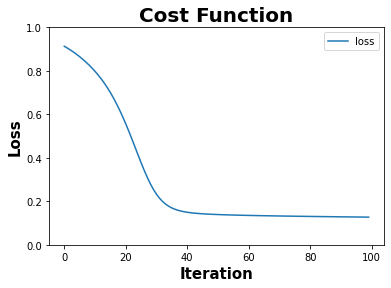

933/933 [==============================] - 0s 397us/step
TN, FP, FN, TP: 28429 3 288 1134
Accuracy = 0.9902525624706907
Precesion = 0.9973614775725593
Recall = 0.7974683544303798
F1 = 0.8862837045720985
F0.5 = 0.949748743718593
F2 = 0.8307692307692308
Gmean = 0.8929637224582653
Balanced Accu. = 0.8986814197588027
################################################## 2th CV ##################################################


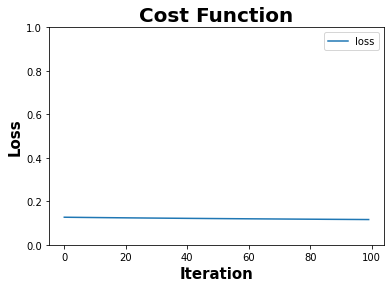

933/933 [==============================] - 0s 397us/step
TN, FP, FN, TP: 28425 7 279 1142
Accuracy = 0.99041972331089
Precesion = 0.9939077458659704
Recall = 0.8036593947923997
F1 = 0.888715953307393
F0.5 = 0.9489778959614427
F2 = 0.8356505195375383
Gmean = 0.896360157901686
Balanced Accu. = 0.9017065966646298
################################################## 3th CV ##################################################


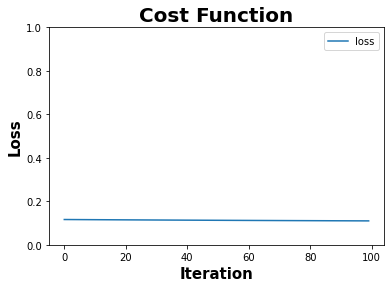

933/933 [==============================] - 0s 395us/step
TN, FP, FN, TP: 28423 9 264 1157
Accuracy = 0.9908551904331223
Precesion = 0.9922813036020584
Recall = 0.8142153413089374
F1 = 0.8944723618090452
F0.5 = 0.9506984387838948
F2 = 0.8445255474452554
Gmean = 0.9021959907507814
Balanced Accu. = 0.9069493982853072
################################################## 4th CV ##################################################


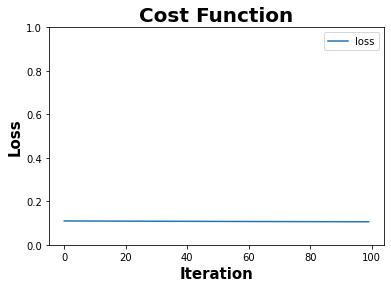

933/933 [==============================] - 0s 406us/step
TN, FP, FN, TP: 28425 7 261 1160
Accuracy = 0.991022677787827
Precesion = 0.9940017137960583
Recall = 0.8163265306122449
F1 = 0.8964451313755796
F0.5 = 0.9525373624568895
F2 = 0.8465917384323456
Gmean = 0.9033966735747968
Balanced Accu. = 0.9080401645745524
################################################## 5th CV ##################################################


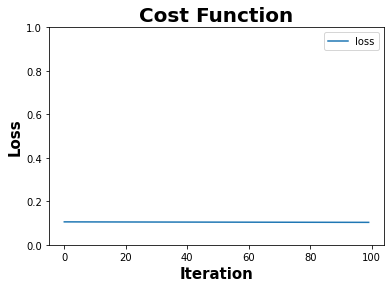

933/933 [==============================] - 0s 395us/step
TN, FP, FN, TP: 28423 9 272 1149
Accuracy = 0.9905872106655947
Precesion = 0.9922279792746114
Recall = 0.8085855031667839
F1 = 0.8910430399379604
F0.5 = 0.9491161407566495
F2 = 0.839666764104063
Gmean = 0.8990714930862129
Balanced Accu. = 0.9041344792142305
################################################## 6th CV ##################################################


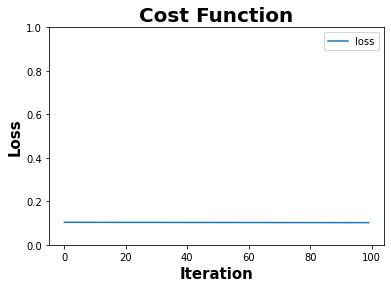

933/933 [==============================] - 0s 393us/step
TN, FP, FN, TP: 28418 13 265 1157
Accuracy = 0.9906877030784176
Precesion = 0.9888888888888889
Recall = 0.8136427566807314
F1 = 0.8927469135802469
F0.5 = 0.9480498197312356
F2 = 0.8435403907844853
Gmean = 0.9018152364367361
Balanced Accu. = 0.9065927546549519
################################################## 7th CV ##################################################


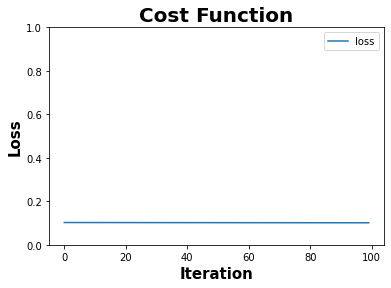

933/933 [==============================] - 0s 396us/step
TN, FP, FN, TP: 28423 8 251 1171
Accuracy = 0.9913241550262956
Precesion = 0.993214588634436
Recall = 0.8234880450070323
F1 = 0.9004229142637448
F0.5 = 0.9538937764744215
F2 = 0.8526285131789719
Gmean = 0.9073347394829422
Balanced Accu. = 0.9116033310048
################################################## 8th CV ##################################################


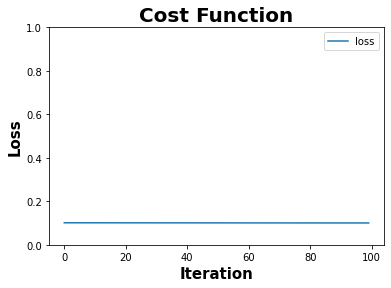

933/933 [==============================] - 0s 394us/step
TN, FP, FN, TP: 28418 13 244 1178
Accuracy = 0.9913911499681775
Precesion = 0.9890848026868178
Recall = 0.8284106891701828
F1 = 0.9016456180635285
F0.5 = 0.9521500161655351
F2 = 0.8562291030673064
Gmean = 0.90996258195631
Balanced Accu. = 0.9139767208996776
################################################## 9th CV ##################################################


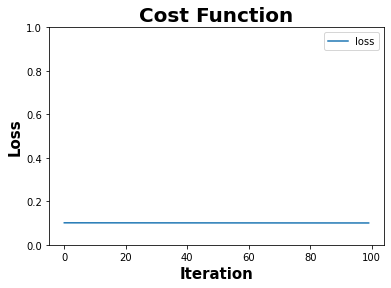

933/933 [==============================] - 0s 393us/step
TN, FP, FN, TP: 28427 4 233 1189
Accuracy = 0.9920610993869963
Precesion = 0.9966471081307627
Recall = 0.8361462728551337
F1 = 0.9093690248565965
F0.5 = 0.9597998062641266
F2 = 0.8639732597006249
Gmean = 0.9143460144731095
Balanced Accu. = 0.9180027906782087
################################################## 10th CV ##################################################


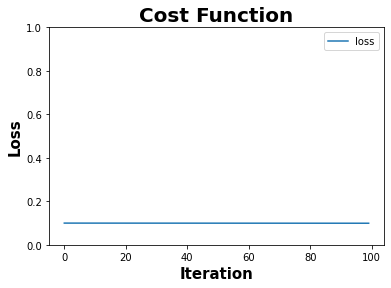

933/933 [==============================] - 0s 399us/step
TN, FP, FN, TP: 28425 6 246 1176
Accuracy = 0.9915586373228821
Precesion = 0.9949238578680203
Recall = 0.8270042194092827
F1 = 0.9032258064516129
F0.5 = 0.9560975609756097
F2 = 0.8558951965065502
Gmean = 0.9093017599865695
Balanced Accu. = 0.9133965910806042


In [265]:
f1_acc = []
f1_f1 = []
f1_f5 = []
f1_f2 = []
f1_gmean = []
f1_bacc = []

n_iter=0

###################### MLP (sigmoid // sigmoid // BCE) ############################## 
batch_size = int(X.shape[0]*0.9 * 0.05)  
print('batch_size: ', batch_size)
learning_rate=0.001

model = Sequential()
model.add(Dense(1, input_dim=X.shape[1], kernel_initializer=kernel_initializer, activation='sigmoid'))
model.summary()
opt = optimizers.Adam(learning_rate = learning_rate)   # SGD(learning_rate=learning_rate, momentum=momentum)

for train_index, test_index in skf.split(df_card, df_card.iloc[:, -1]):
    n_iter += 1
    X_train = X.iloc[train_index]
    y_train= y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test= y.iloc[test_index]
    print('#'*50,'{0}th CV'.format(n_iter),'#'*50)
#     print('Labels for train:\n', label_train.value_counts())
#     print('Labels for test:\n', label_test.value_counts())
#     print(len(X_train), len(y_train), len(X_test), len(y_test))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_test = y_test.astype(float)
    
    model.compile(loss=SOL(score = 'f1_score', distribution = 'cosine', mu = 0.5, delta = 0.1, mode = 'average'), optimizer=opt)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=len(X_train))
    plt.plot(history.history['loss'], label='loss')
    plt.ylim([0, 1])
    plt.xlabel('Iteration',fontweight="bold",fontsize = 15)
    plt.ylabel('Loss',fontweight="bold",fontsize = 15)
    plt.title("Cost Function",fontweight="bold",fontsize = 20)
    plt.legend()
    plt.show()    
    predicted = np.round(model.predict(X_test))
    TN = metrics.confusion_matrix(y_test, predicted)[0,0]
    FP = metrics.confusion_matrix(y_test, predicted)[0,1]
    FN = metrics.confusion_matrix(y_test, predicted)[1,0]
    TP = metrics.confusion_matrix(y_test, predicted)[1,1]
    print("TN, FP, FN, TP:", TN, FP, FN, TP)
    print('Accuracy =', (TP+TN)/(TP+TN+FP+FN))
    print('Precesion =', TP/(TP+FP))
    print('Recall =', TP/(TP+FN))
    print('F1 =', TP / (TP + 0.5*(FP+FN)))
    print('F0.5 =', TP / (TP + 0.8*FP + 0.2*FN))
    print('F2 =', TP / (TP + 0.2*FP + 0.8*FN))
    print('Gmean =', ((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    print('Balanced Accu. =', 0.5*(TP/(TP+FN) + TN/(TN+FP)))
    f1_acc.append((TP+TN)/(TP+TN+FP+FN))
    f1_f1.append(TP / (TP + 0.5*(FP+FN)))
    f1_f5.append(TP / (TP + 0.8*FP + 0.2*FN))
    f1_f2.append(TP / (TP + 0.2*FP + 0.8*FN))
    f1_gmean.append(((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    f1_bacc.append(0.5*(TP/(TP+FN) + TN/(TN+FP)))    

In [266]:
res['F1Aim'] = [np.mean(f1_acc), np.mean(f1_f1), np.mean(f1_f5), np.mean(f1_f2), np.mean(f1_gmean), np.mean(f1_bacc)]
res

,Delta,BCE,AccAim,F1Aim,F.5Aim,F2Aim,GAim,BAim
Acc,0,0,0.990832,0.991016,0,0,0,0
F1,0,0,0.894053,0.896437,0,0,0,0
F.5,0,0,0.951147,0.952107,0,0,0,0
F2,0,0,0.843461,0.846947,0,0,0,0
Gmean,0,0,0.901414,0.903675,0,0,0,0
B_Acc,0,0,0.906273,0.908308,0,0,0,0


batch_size:  134338
Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_61 (Dense)            (None, 1)                 30        
                                                                 
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
################################################## 1th CV ##################################################


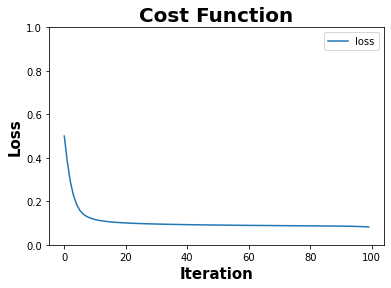

933/933 [==============================] - 0s 395us/step
TN, FP, FN, TP: 28389 43 229 1193
Accuracy = 0.9908889930997521
Precesion = 0.9652103559870551
Recall = 0.8389592123769339
F1 = 0.8976674191121143
F0.5 = 0.937009110901665
F2 = 0.8614962449451185
Gmean = 0.9152542744472433
Balanced Accu. = 0.9187234159802509
################################################## 2th CV ##################################################


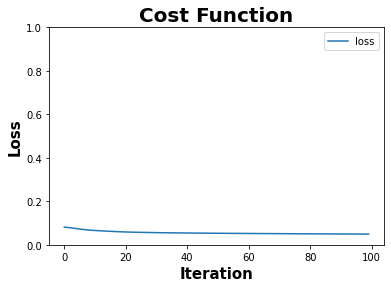

933/933 [==============================] - 0s 393us/step
TN, FP, FN, TP: 28107 325 105 1316
Accuracy = 0.9855960874953941
Precesion = 0.8019500304692261
Recall = 0.9261083743842364
F1 = 0.8595689092096669
F0.5 = 0.8240450845335003
F2 = 0.8982935153583618
Gmean = 0.9568292591926245
Balanced Accu. = 0.9573387960835082
################################################## 3th CV ##################################################


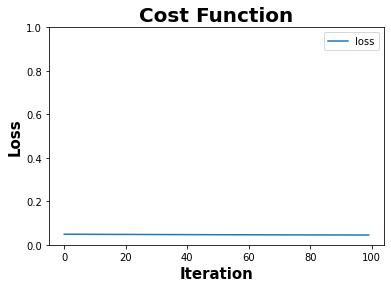

933/933 [==============================] - 0s 386us/step
TN, FP, FN, TP: 28068 364 109 1312
Accuracy = 0.9841556962449335
Precesion = 0.7828162291169452
Recall = 0.9232934553131598
F1 = 0.8472715531159186
F0.5 = 0.8073846153846154
F2 = 0.8913043478260869
Gmean = 0.9547109577949014
Balanced Accu. = 0.9552454896149367
################################################## 4th CV ##################################################


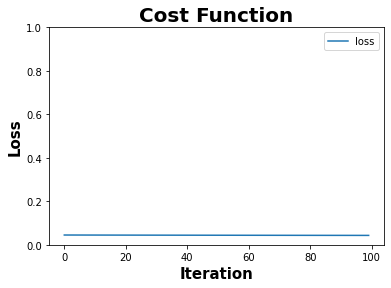

933/933 [==============================] - 0s 397us/step
TN, FP, FN, TP: 28073 359 107 1314
Accuracy = 0.9843901785415201
Precesion = 0.785415421398685
Recall = 0.9247009148486981
F1 = 0.8493859082094376
F0.5 = 0.8098114137803525
F2 = 0.8930270490689141
Gmean = 0.9555234532597524
Balanced Accu. = 0.9560371484766844
################################################## 5th CV ##################################################


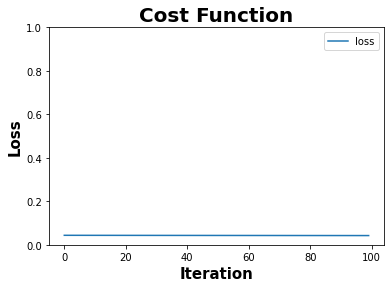

933/933 [==============================] - 0s 396us/step
TN, FP, FN, TP: 28062 370 85 1336
Accuracy = 0.9847586507218705
Precesion = 0.7831184056271981
Recall = 0.94018296973962
F1 = 0.8544931244003837
F0.5 = 0.8101879927228623
F2 = 0.9039242219215156
Gmean = 0.9633005206619206
Balanced Accu. = 0.9635847319153925
################################################## 6th CV ##################################################


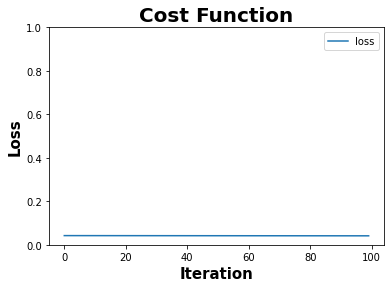

933/933 [==============================] - 0s 398us/step
TN, FP, FN, TP: 28035 396 90 1332
Accuracy = 0.9837202291227012
Precesion = 0.7708333333333334
Recall = 0.9367088607594937
F1 = 0.8457142857142858
F0.5 = 0.7991360691144709
F2 = 0.8980582524271844
Gmean = 0.96107333246994
Balanced Accu. = 0.9613902011932954
################################################## 7th CV ##################################################


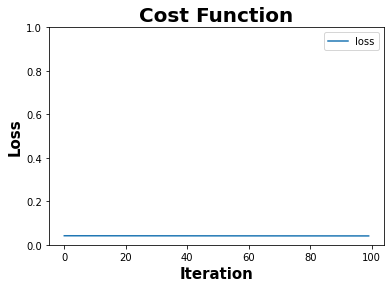

933/933 [==============================] - 0s 388us/step
TN, FP, FN, TP: 28013 418 77 1345
Accuracy = 0.9834187518842328
Precesion = 0.7629041406693137
Recall = 0.9458509142053446
F1 = 0.8445839874411303
F0.5 = 0.7936039650696246
F2 = 0.9025634143068045
Gmean = 0.9653728640349875
Balanced Accu. = 0.9655743262947514
################################################## 8th CV ##################################################


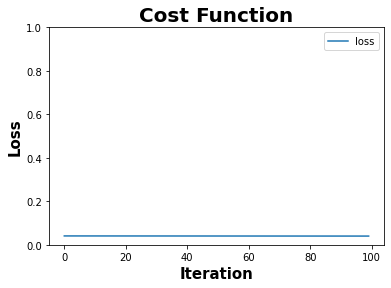

933/933 [==============================] - 0s 394us/step
TN, FP, FN, TP: 27985 446 76 1346
Accuracy = 0.9825143201688272
Precesion = 0.7511160714285714
Recall = 0.9465541490857946
F1 = 0.8375855631611698
F0.5 = 0.7834691501746216
F2 = 0.8997326203208557
Gmean = 0.9652489096079925
Balanced Accu. = 0.9654335234894698
################################################## 9th CV ##################################################


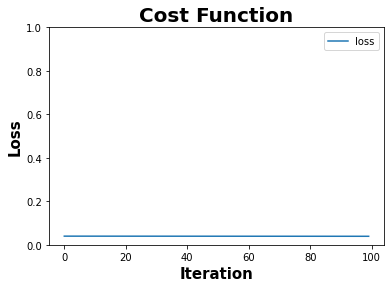

933/933 [==============================] - 0s 394us/step
TN, FP, FN, TP: 28026 405 83 1339
Accuracy = 0.9836532341808194
Precesion = 0.7677752293577982
Recall = 0.9416315049226441
F1 = 0.8458622867972204
F0.5 = 0.7972136222910217
F2 = 0.9008342303552206
Gmean = 0.9634406835511291
Balanced Accu. = 0.963693245338815
################################################## 10th CV ##################################################


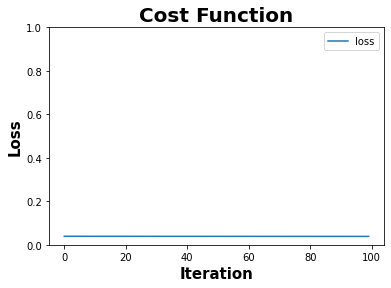

933/933 [==============================] - 0s 389us/step
TN, FP, FN, TP: 27973 458 85 1337
Accuracy = 0.9818108732790675
Precesion = 0.7448467966573816
Recall = 0.940225035161744
F1 = 0.831209201119055
F0.5 = 0.7771448500348755
F2 = 0.8933582787652011
Gmean = 0.9618101600751356
Balanced Accu. = 0.9620579292793701


In [269]:
bacc_acc = []
bacc_f1 = []
bacc_f5 = []
bacc_f2 = []
bacc_gmean = []
bacc_bacc = []

n_iter=0

###################### MLP (sigmoid // sigmoid // BCE) ############################## 
batch_size = int(X.shape[0]*0.9 * 0.5)  
print('batch_size: ', batch_size)
learning_rate=0.005

model = Sequential()
model.add(Dense(1, input_dim=X.shape[1], kernel_initializer=kernel_initializer, activation='sigmoid'))
model.summary()
opt = optimizers.Adam(learning_rate = learning_rate)   # SGD(learning_rate=learning_rate, momentum=momentum)

for train_index, test_index in skf.split(df_card, df_card.iloc[:, -1]):
    n_iter += 1
    X_train = X.iloc[train_index]
    y_train= y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test= y.iloc[test_index]
    print('#'*50,'{0}th CV'.format(n_iter),'#'*50)
#     print('Labels for train:\n', label_train.value_counts())
#     print('Labels for test:\n', label_test.value_counts())
#     print(len(X_train), len(y_train), len(X_test), len(y_test))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_test = y_test.astype(float)
    
    model.compile(loss=SOL(score = 'bacc', distribution = 'cosine', mu = 0.5, delta = 0.1, mode = 'average'), optimizer=opt)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=len(X_train))
    plt.plot(history.history['loss'], label='loss')
    plt.ylim([0, 1])
    plt.xlabel('Iteration',fontweight="bold",fontsize = 15)
    plt.ylabel('Loss',fontweight="bold",fontsize = 15)
    plt.title("Cost Function",fontweight="bold",fontsize = 20)
    plt.legend()
    plt.show()    
    predicted = np.round(model.predict(X_test))
    TN = metrics.confusion_matrix(y_test, predicted)[0,0]
    FP = metrics.confusion_matrix(y_test, predicted)[0,1]
    FN = metrics.confusion_matrix(y_test, predicted)[1,0]
    TP = metrics.confusion_matrix(y_test, predicted)[1,1]
    print("TN, FP, FN, TP:", TN, FP, FN, TP)
    print('Accuracy =', (TP+TN)/(TP+TN+FP+FN))
    print('Precesion =', TP/(TP+FP))
    print('Recall =', TP/(TP+FN))
    print('F1 =', TP / (TP + 0.5*(FP+FN)))
    print('F0.5 =', TP / (TP + 0.8*FP + 0.2*FN))
    print('F2 =', TP / (TP + 0.2*FP + 0.8*FN))
    print('Gmean =', ((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    print('Balanced Accu. =', 0.5*(TP/(TP+FN) + TN/(TN+FP)))
    bacc_acc.append((TP+TN)/(TP+TN+FP+FN))
    bacc_f1.append(TP / (TP + 0.5*(FP+FN)))
    bacc_f5.append(TP / (TP + 0.8*FP + 0.2*FN))
    bacc_f2.append(TP / (TP + 0.2*FP + 0.8*FN))
    bacc_gmean.append(((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    bacc_bacc.append(0.5*(TP/(TP+FN) + TN/(TN+FP)))    

In [270]:
res['BAim'] = [np.mean(bacc_acc), np.mean(bacc_f1), np.mean(bacc_f5), np.mean(bacc_f2), np.mean(bacc_gmean), np.mean(bacc_bacc)]
res

,Delta,BCE,AccAim,F1Aim,F.5Aim,F2Aim,GAim,BAim
Acc,0,0,0.990832,0.991016,0,0,0,0.984491
F1,0,0,0.894053,0.896437,0,0,0,0.851334
F.5,0,0,0.951147,0.952107,0,0,0,0.813901
F2,0,0,0.843461,0.846947,0,0,0,0.894259
Gmean,0,0,0.901414,0.903675,0,0,0,0.956256
B_Acc,0,0,0.906273,0.908308,0,0,0,0.956908


# 3. Breast Cancer Data (30d / 569)

In [21]:
# class 'B' = Benign, class 'M' = Malignant
cancer_df = pd.read_csv('breast_cancer.csv')
cancer_df.shape

(569, 32)

In [22]:
cancer_df.isnull().sum()

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [23]:
cancer_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [24]:
cancer_df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [25]:
# M/Malignant = 0, B/Benign = 1
y_encoded, y_class = pd.factorize(cancer_df['diagnosis'])
print(y_class)
y_encoded

Index(['M', 'B'], dtype='object')


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

In [26]:
# But I want [B/Benign = 0(Major), M/Malignant = 1(minor)]
y_encoded = (y_encoded+1)%2
y_encoded

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,

In [27]:
cancer_df['label'] = y_encoded
cancer_df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,label
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,1
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,1
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,1
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,1
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,1
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,1
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,1
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,1


In [28]:
cancer_df = cancer_df.drop('id', axis=1)
cancer_df = cancer_df.drop('diagnosis', axis=1)
cancer_df

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,label
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,1
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,1
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,1
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,1


In [29]:
# Amount values largely varies.

# # Normalization
# card_df.iloc[:,:-1] = (card_df.iloc[:,:-1] - card_df.iloc[:,:-1].min())/(card_df.iloc[:,:-1].max() - card_df.iloc[:,:-1].min())

# Standardization
cancer_df.iloc[:,:-1] = (cancer_df.iloc[:,:-1] - cancer_df.iloc[:,:-1].mean())/cancer_df.iloc[:,:-1].std()

cancer_df

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,label
0,1.096100,-2.071512,1.268817,0.983510,1.567087,3.280628,2.650542,2.530249,2.215566,2.253764,...,-1.358098,2.301575,1.999478,1.306537,2.614365,2.107672,2.294058,2.748204,1.935312,1
1,1.828212,-0.353322,1.684473,1.907030,-0.826235,-0.486643,-0.023825,0.547662,0.001391,-0.867889,...,-0.368879,1.533776,1.888827,-0.375282,-0.430066,-0.146620,1.086129,-0.243675,0.280943,1
2,1.578499,0.455786,1.565126,1.557513,0.941382,1.052000,1.362280,2.035440,0.938859,-0.397658,...,-0.023953,1.346291,1.455004,0.526944,1.081980,0.854222,1.953282,1.151242,0.201214,1
3,-0.768233,0.253509,-0.592166,-0.763792,3.280667,3.399917,1.914213,1.450431,2.864862,4.906602,...,0.133866,-0.249720,-0.549538,3.391291,3.889975,1.987839,2.173873,6.040726,4.930672,1
4,1.748758,-1.150804,1.775011,1.824624,0.280125,0.538866,1.369806,1.427237,-0.009552,-0.561956,...,-1.465481,1.337363,1.219651,0.220362,-0.313119,0.612640,0.728618,-0.867590,-0.396751,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,2.109139,0.720838,2.058974,2.341795,1.040926,0.218868,1.945573,2.318924,-0.312314,-0.930209,...,0.117596,1.751022,2.013529,0.378033,-0.273077,0.663928,1.627719,-1.358963,-0.708467,1
565,1.703356,2.083301,1.614511,1.722326,0.102368,-0.017817,0.692434,1.262558,-0.217473,-1.057681,...,2.045599,1.420690,1.493644,-0.690623,-0.394473,0.236365,0.733182,-0.531387,-0.973122,1
566,0.701667,2.043775,0.672084,0.577445,-0.839745,-0.038646,0.046547,0.105684,-0.808406,-0.894800,...,1.373645,0.578492,0.427529,-0.808876,0.350427,0.326479,0.413705,-1.103578,-0.318129,1
567,1.836725,2.334403,1.980781,1.733693,1.524426,3.269267,3.294046,2.656528,2.135315,1.042778,...,2.235958,2.301575,1.651717,1.429169,3.901415,3.194794,2.287972,1.917396,2.217684,1


In [30]:
cancer_df['label'].value_counts()

0    357
1    212
Name: label, dtype: int64

In [31]:
# Data is too balanced!!! We intentionally make it imbalanced.
df_0 = cancer_df[cancer_df['label']==0]
df_1 = cancer_df[cancer_df['label']==1]
print(len(df_0), len(df_1))

357 212


In [32]:
N = round(len(df_0)*0.1)
df_1_samp = df_1.sample(n=N, random_state = 100)
df_1_samp

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,label
219,1.533097,3.064460,1.482818,1.614345,-0.864631,0.163957,0.322388,0.449731,-1.399339,-1.369279,...,3.210535,2.170633,2.803894,0.369273,0.987914,0.610243,0.728618,-0.303481,-0.457654,1
45,1.283384,-0.392847,1.305856,1.196630,0.962713,1.216733,1.362280,1.339615,0.347926,-0.326840,...,-0.708923,1.289747,1.205600,1.556182,1.619046,2.216001,1.874173,1.451885,0.437632,1
408,1.096100,0.318610,1.063047,0.957083,0.514765,0.493423,0.392634,1.013350,0.657983,-0.298513,...,-0.043477,0.917752,0.822712,0.693374,0.757834,0.277588,1.259559,0.257396,0.060028,1
156,1.008133,0.337210,1.046586,0.877518,1.076478,1.176970,1.213007,1.455585,0.581381,-0.161126,...,-0.092288,0.763001,0.740163,0.413071,0.607202,0.412759,0.561273,-0.707570,-0.363530,1
213,0.934354,1.457870,0.927239,0.832905,0.301456,0.194253,0.995997,0.439423,-1.837067,-0.586034,...,0.389306,0.391006,0.246624,-0.353383,-0.476463,0.038881,-0.071597,-2.097638,-0.872908,1
100,-0.146789,1.323019,-0.161284,-0.205133,-0.105252,-0.364135,-0.031978,-0.103836,-0.739099,-0.578952,...,1.560751,0.039842,0.045520,-0.257029,-0.381126,0.214316,0.057716,-0.403695,-0.552332,1
372,2.055224,-0.974102,2.030166,2.077526,0.265905,0.892947,1.309595,1.973589,0.588676,-0.137048,...,-0.624319,1.334387,1.149396,-0.576750,0.188990,0.624144,1.247389,-0.276002,0.150276,1
212,3.967796,-0.190570,3.972634,5.240230,1.268455,0.894841,2.901420,2.849813,-0.596837,-1.069012,...,-1.172620,2.417638,2.842534,-0.795736,-0.652519,0.229655,0.682979,-2.024902,-1.588804,1
433,1.331624,0.623187,1.305856,1.293244,0.386780,0.654369,0.885610,0.992733,0.479244,-0.209282,...,0.854630,1.132021,1.268829,0.290438,0.584956,0.570459,0.854888,0.171729,-0.044616,1
365,1.791323,0.579012,1.721511,1.813257,-0.345580,0.165850,0.115287,0.745586,-0.706269,-1.023688,...,0.112715,1.605200,1.579706,0.014515,-0.105920,-0.009531,0.941603,-0.471582,-0.918862,1


In [33]:
cancer_df = concath(df_0, df_1_samp)
cancer_df

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,label
19,-0.166653,-1.146154,-0.185565,-0.251735,0.101657,-0.436466,-0.277965,-0.028584,0.267676,-0.727669,...,-1.044086,-0.225019,-0.297499,0.509425,-0.489175,-0.159083,0.215933,0.123238,-0.628739,0
20,-0.297184,-0.832276,-0.260877,-0.383301,0.792066,0.429044,-0.540886,-0.459223,0.566790,0.752425,...,-0.843964,-0.332451,-0.439238,-0.051181,0.148312,-0.398748,-0.635551,0.457824,-0.117147,0
21,-1.311926,-1.592558,-1.301661,-1.082620,0.429441,-0.746429,-0.743094,-0.725698,0.012334,0.885562,...,-1.629809,-1.253810,-0.993547,0.001375,-0.886413,-0.879660,-0.796202,-0.728583,-0.344152,0
37,-0.311372,-0.202195,-0.385162,-0.372503,-0.464322,-1.262592,-0.792517,-0.507415,-1.257077,-0.590283,...,-0.466499,-0.678556,-0.587827,-1.548613,-1.322484,-1.073022,-0.980890,-1.476957,-1.232240,0
46,-1.683090,-0.569549,-1.656820,-1.287215,-0.736646,-0.850381,-0.914695,-1.108221,-0.155461,0.316186,...,-0.604795,-1.488019,-1.121235,-0.116877,-0.753576,-0.974903,-1.353462,0.330132,-0.545688,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,0.117112,1.918224,0.195933,0.011113,1.247125,1.044426,0.942058,0.637089,1.792428,1.129176,...,1.863374,0.501116,0.109978,1.551802,2.564154,2.063094,0.860973,2.129139,2.776892,1
489,0.727206,0.211659,0.622700,0.576024,-1.520911,-0.629033,-0.656165,-0.666166,0.125414,-1.352283,...,0.143628,0.596347,0.357275,-1.378241,0.239836,-0.117381,-0.414350,2.871047,-0.427202,1
451,1.550123,1.327669,1.470472,1.523414,0.486324,-0.106622,0.962128,1.074943,-0.542121,-1.258804,...,0.859511,0.968343,0.949171,0.894842,-0.443413,0.601615,0.486728,-0.982351,-1.275426,1
223,0.460467,0.223284,0.437507,0.302377,0.436552,0.304075,0.324896,0.404632,0.450062,0.032915,...,0.750502,0.554684,0.364300,0.999955,1.231342,0.601136,0.506505,1.765458,1.243223,1


In [34]:
cancer_df['label'].value_counts()

0    357
1     36
Name: label, dtype: int64

In [35]:
res = pd.DataFrame({'Delta':[0, 0, 0, 0, 0, 0],
                    'BCE':[0, 0, 0, 0, 0, 0],
                    'AccAim':[0, 0, 0, 0, 0, 0],
                    'F1Aim':[0, 0, 0, 0, 0, 0],
                    'F.5Aim':[0, 0, 0, 0, 0, 0],
                    'F2Aim':[0, 0, 0, 0, 0, 0],
                    'GAim':[0, 0, 0, 0, 0, 0],
                    'BAim':[0, 0, 0, 0, 0, 0]}, index = ['Acc','F1','F.5','F2','Gmean','B_Acc'])

In [36]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state = 2)

X = cancer_df.iloc[:, :-1]
y = cancer_df.iloc[:, -1]

In [37]:
L = 73
hidden_node = 2
# momentum=0.9
activation = 'sigmoid'  
kernel_initializer=keras.initializers.Zeros
epochs=100

batch_size:  17
Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_80 (Dense)            (None, 1)                 31        
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________
################################################## 1th CV ##################################################


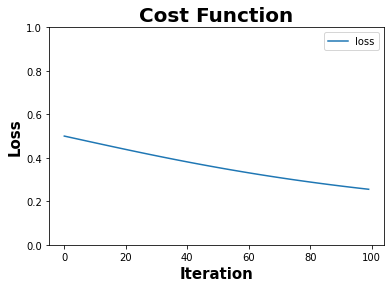

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 33 3 0 4
Accuracy = 0.925
Precesion = 0.5714285714285714
Recall = 1.0
F1 = 0.7272727272727273
F0.5 = 0.625
F2 = 0.8695652173913044
Gmean = 0.9574271077563381
Balanced Accu. = 0.9583333333333333
################################################## 2th CV ##################################################


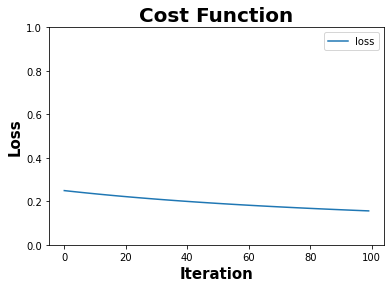

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 35 1 1 3
Accuracy = 0.95
Precesion = 0.75
Recall = 0.75
F1 = 0.75
F0.5 = 0.75
F2 = 0.75
Gmean = 0.8539125638299665
Balanced Accu. = 0.8611111111111112
################################################## 3th CV ##################################################


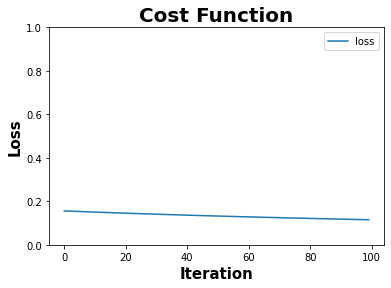

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 36 0 0 4
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0
################################################## 4th CV ##################################################


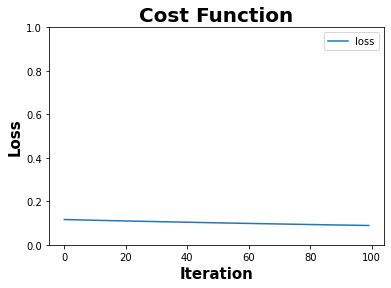

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 36 0 0 3
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0
################################################## 5th CV ##################################################


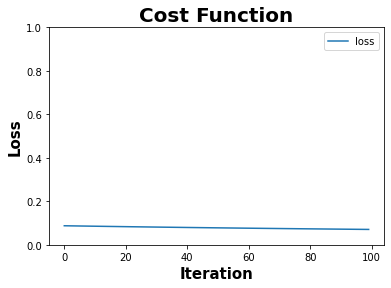

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 36 0 0 3
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0
################################################## 6th CV ##################################################


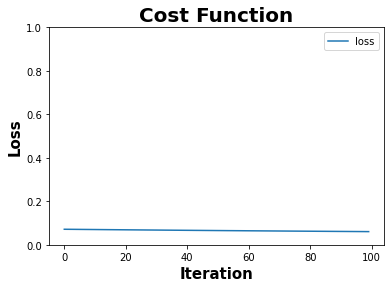

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 35 1 0 3
Accuracy = 0.9743589743589743
Precesion = 0.75
Recall = 1.0
F1 = 0.8571428571428571
F0.5 = 0.7894736842105263
F2 = 0.9375
Gmean = 0.9860132971832694
Balanced Accu. = 0.9861111111111112
################################################## 7th CV ##################################################


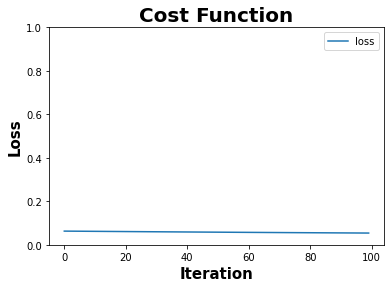

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 36 0 0 3
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0
################################################## 8th CV ##################################################


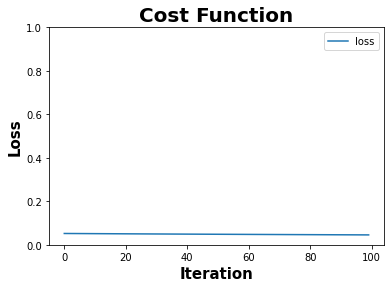

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 34 1 0 4
Accuracy = 0.9743589743589743
Precesion = 0.8
Recall = 1.0
F1 = 0.8888888888888888
F0.5 = 0.8333333333333334
F2 = 0.9523809523809523
Gmean = 0.9856107606091623
Balanced Accu. = 0.9857142857142858
################################################## 9th CV ##################################################


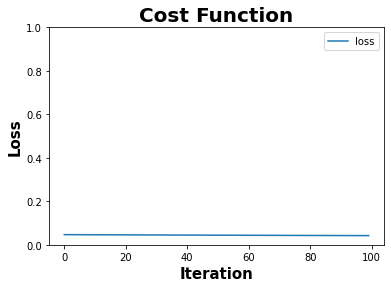

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 35 0 0 4
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0
################################################## 10th CV ##################################################


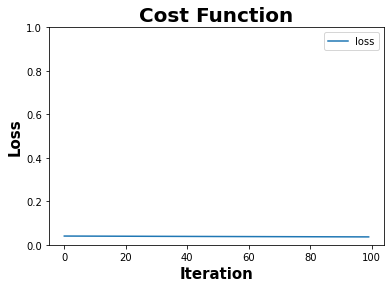

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 35 0 1 3
Accuracy = 0.9743589743589743
Precesion = 1.0
Recall = 0.75
F1 = 0.8571428571428571
F0.5 = 0.9375
F2 = 0.7894736842105263
Gmean = 0.8660254037844386
Balanced Accu. = 0.875


In [340]:
acc_acc = []
acc_f1 = []
acc_f5 = []
acc_f2 = []
acc_gmean = []
acc_bacc = []

n_iter=0

###################### MLP (sigmoid // sigmoid // BCE) ############################## 
batch_size = int(X.shape[0]*0.9 * 0.05)  
print('batch_size: ', batch_size)
learning_rate=0.0001

model = Sequential()
model.add(Dense(1, input_dim=X.shape[1], kernel_initializer=kernel_initializer, activation='sigmoid'))
model.summary()
opt = optimizers.Adam(learning_rate = learning_rate)   # SGD(learning_rate=learning_rate, momentum=momentum)

for train_index, test_index in skf.split(cancer_df, cancer_df.iloc[:, -1]):
    n_iter += 1
    X_train = X.iloc[train_index]
    y_train= y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test= y.iloc[test_index]
    print('#'*50,'{0}th CV'.format(n_iter),'#'*50)
#     print('Labels for train:\n', label_train.value_counts())
#     print('Labels for test:\n', label_test.value_counts())
#     print(len(X_train), len(y_train), len(X_test), len(y_test))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_test = y_test.astype(float)
    
    model.compile(loss=SOL(score = 'accuracy', distribution = 'cosine', mu = 0.5, delta = 0.1, mode = 'average'), optimizer=opt)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=len(X_train))
    plt.plot(history.history['loss'], label='loss')
    plt.ylim([0, 1])
    plt.xlabel('Iteration',fontweight="bold",fontsize = 15)
    plt.ylabel('Loss',fontweight="bold",fontsize = 15)
    plt.title("Cost Function",fontweight="bold",fontsize = 20)
    plt.legend()
    plt.show()    
    predicted = np.round(model.predict(X_test))
    TN = metrics.confusion_matrix(y_test, predicted)[0,0]
    FP = metrics.confusion_matrix(y_test, predicted)[0,1]
    FN = metrics.confusion_matrix(y_test, predicted)[1,0]
    TP = metrics.confusion_matrix(y_test, predicted)[1,1]
    print("TN, FP, FN, TP:", TN, FP, FN, TP)
    print('Accuracy =', (TP+TN)/(TP+TN+FP+FN))
    print('Precesion =', TP/(TP+FP))
    print('Recall =', TP/(TP+FN))
    print('F1 =', TP / (TP + 0.5*(FP+FN)))
    print('F0.5 =', TP / (TP + 0.8*FP + 0.2*FN))
    print('F2 =', TP / (TP + 0.2*FP + 0.8*FN))
    print('Gmean =', ((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    print('Balanced Accu. =', 0.5*(TP/(TP+FN) + TN/(TN+FP)))
    acc_acc.append((TP+TN)/(TP+TN+FP+FN))
    acc_f1.append(TP / (TP + 0.5*(FP+FN)))
    acc_f5.append(TP / (TP + 0.8*FP + 0.2*FN))
    acc_f2.append(TP / (TP + 0.2*FP + 0.8*FN))
    acc_gmean.append(((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    acc_bacc.append(0.5*(TP/(TP+FN) + TN/(TN+FP)))    

In [341]:
res['AccAim'] = [np.mean(acc_acc), np.mean(acc_f1), np.mean(acc_f5), np.mean(acc_f2), np.mean(acc_gmean), np.mean(acc_bacc)]
res

,Delta,BCE,AccAim,F1Aim,F.5Aim,F2Aim,GAim,BAim
Acc,0,0,0.979808,0.982372,0,0,0,0.977244
F1,0,0,0.908045,0.922330,0,0,0,0.893759
F.5,0,0,0.893531,0.914583,0,0,0,0.872478
F2,0,0,0.929892,0.936142,0,0,0,0.923642
Gmean,0,0,0.964899,0.966298,0,0,0,0.963500
B_Acc,0,0,0.966627,0.968016,0,0,0,0.965238


batch_size:  17
Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_81 (Dense)            (None, 1)                 31        
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________
################################################## 1th CV ##################################################


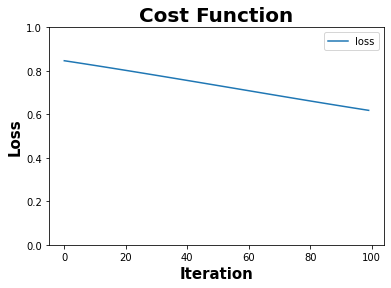

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 33 3 0 4
Accuracy = 0.925
Precesion = 0.5714285714285714
Recall = 1.0
F1 = 0.7272727272727273
F0.5 = 0.625
F2 = 0.8695652173913044
Gmean = 0.9574271077563381
Balanced Accu. = 0.9583333333333333
################################################## 2th CV ##################################################


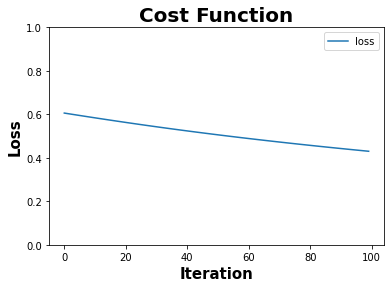

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 35 1 1 3
Accuracy = 0.95
Precesion = 0.75
Recall = 0.75
F1 = 0.75
F0.5 = 0.75
F2 = 0.75
Gmean = 0.8539125638299665
Balanced Accu. = 0.8611111111111112
################################################## 3th CV ##################################################


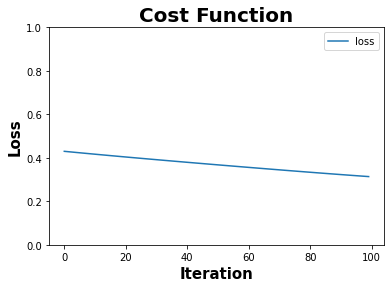

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 36 0 0 4
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0
################################################## 4th CV ##################################################


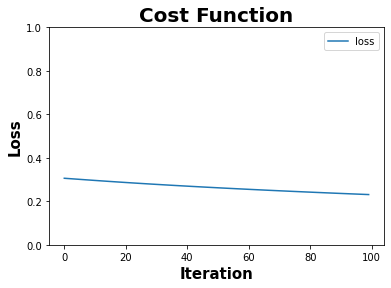

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 36 0 0 3
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0
################################################## 5th CV ##################################################


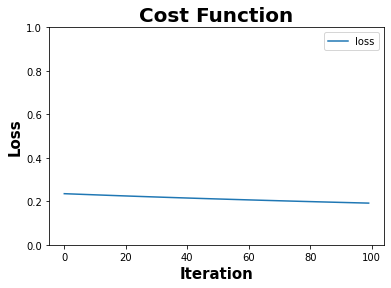

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 36 0 0 3
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0
################################################## 6th CV ##################################################


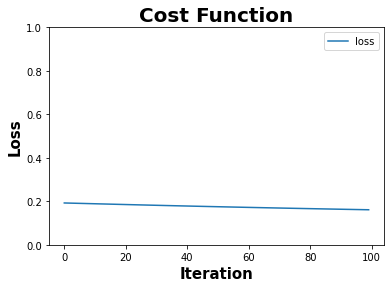

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 36 0 0 3
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0
################################################## 7th CV ##################################################


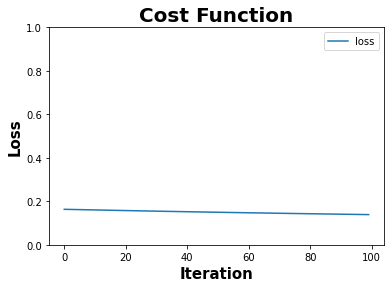

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 36 0 0 3
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0
################################################## 8th CV ##################################################


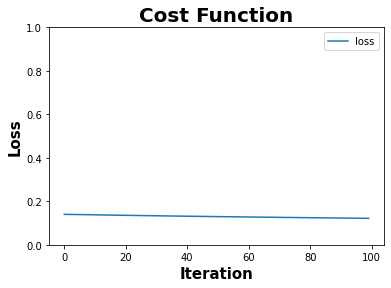

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 34 1 0 4
Accuracy = 0.9743589743589743
Precesion = 0.8
Recall = 1.0
F1 = 0.8888888888888888
F0.5 = 0.8333333333333334
F2 = 0.9523809523809523
Gmean = 0.9856107606091623
Balanced Accu. = 0.9857142857142858
################################################## 9th CV ##################################################


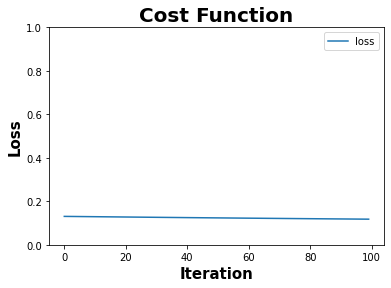

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 35 0 0 4
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0
################################################## 10th CV ##################################################


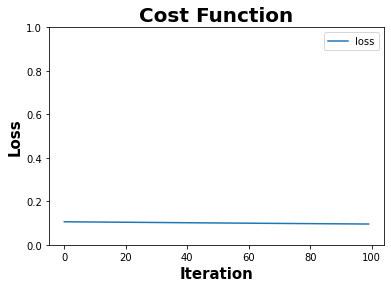

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 35 0 1 3
Accuracy = 0.9743589743589743
Precesion = 1.0
Recall = 0.75
F1 = 0.8571428571428571
F0.5 = 0.9375
F2 = 0.7894736842105263
Gmean = 0.8660254037844386
Balanced Accu. = 0.875


In [342]:
f1_acc = []
f1_f1 = []
f1_f5 = []
f1_f2 = []
f1_gmean = []
f1_bacc = []

n_iter=0

###################### MLP (sigmoid // sigmoid // BCE) ############################## 
batch_size = int(X.shape[0]*0.9 * 0.05)  
print('batch_size: ', batch_size)
learning_rate=0.0001

model = Sequential()
model.add(Dense(1, input_dim=X.shape[1], kernel_initializer=kernel_initializer, activation='sigmoid'))
model.summary()
opt = optimizers.Adam(learning_rate = learning_rate)   # SGD(learning_rate=learning_rate, momentum=momentum)

for train_index, test_index in skf.split(cancer_df, cancer_df.iloc[:, -1]):
    n_iter += 1
    X_train = X.iloc[train_index]
    y_train= y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test= y.iloc[test_index]
    print('#'*50,'{0}th CV'.format(n_iter),'#'*50)
#     print('Labels for train:\n', label_train.value_counts())
#     print('Labels for test:\n', label_test.value_counts())
#     print(len(X_train), len(y_train), len(X_test), len(y_test))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_test = y_test.astype(float)
    
    model.compile(loss=SOL(score = 'f1_score', distribution = 'cosine', mu = 0.5, delta = 0.1, mode = 'average'), optimizer=opt)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=len(X_train))
    plt.plot(history.history['loss'], label='loss')
    plt.ylim([0, 1])
    plt.xlabel('Iteration',fontweight="bold",fontsize = 15)
    plt.ylabel('Loss',fontweight="bold",fontsize = 15)
    plt.title("Cost Function",fontweight="bold",fontsize = 20)
    plt.legend()
    plt.show()    
    predicted = np.round(model.predict(X_test))
    TN = metrics.confusion_matrix(y_test, predicted)[0,0]
    FP = metrics.confusion_matrix(y_test, predicted)[0,1]
    FN = metrics.confusion_matrix(y_test, predicted)[1,0]
    TP = metrics.confusion_matrix(y_test, predicted)[1,1]
    print("TN, FP, FN, TP:", TN, FP, FN, TP)
    print('Accuracy =', (TP+TN)/(TP+TN+FP+FN))
    print('Precesion =', TP/(TP+FP))
    print('Recall =', TP/(TP+FN))
    print('F1 =', TP / (TP + 0.5*(FP+FN)))
    print('F0.5 =', TP / (TP + 0.8*FP + 0.2*FN))
    print('F2 =', TP / (TP + 0.2*FP + 0.8*FN))
    print('Gmean =', ((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    print('Balanced Accu. =', 0.5*(TP/(TP+FN) + TN/(TN+FP)))
    f1_acc.append((TP+TN)/(TP+TN+FP+FN))
    f1_f1.append(TP / (TP + 0.5*(FP+FN)))
    f1_f5.append(TP / (TP + 0.8*FP + 0.2*FN))
    f1_f2.append(TP / (TP + 0.2*FP + 0.8*FN))
    f1_gmean.append(((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    f1_bacc.append(0.5*(TP/(TP+FN) + TN/(TN+FP)))    

In [343]:
res['F1Aim'] = [np.mean(f1_acc), np.mean(f1_f1), np.mean(f1_f5), np.mean(f1_f2), np.mean(f1_gmean), np.mean(f1_bacc)]
res

,Delta,BCE,AccAim,F1Aim,F.5Aim,F2Aim,GAim,BAim
Acc,0,0,0.979808,0.982372,0,0,0,0.977244
F1,0,0,0.908045,0.922330,0,0,0,0.893759
F.5,0,0,0.893531,0.914583,0,0,0,0.872478
F2,0,0,0.929892,0.936142,0,0,0,0.923642
Gmean,0,0,0.964899,0.966298,0,0,0,0.963500
B_Acc,0,0,0.966627,0.968016,0,0,0,0.965238


batch_size:  176
Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_82 (Dense)            (None, 1)                 31        
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________
################################################## 1th CV ##################################################


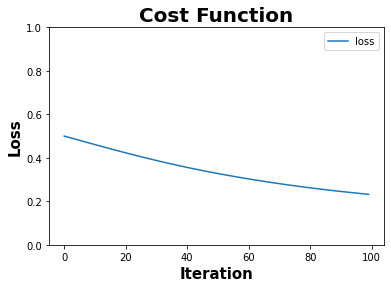

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 33 3 0 4
Accuracy = 0.925
Precesion = 0.5714285714285714
Recall = 1.0
F1 = 0.7272727272727273
F0.5 = 0.625
F2 = 0.8695652173913044
Gmean = 0.9574271077563381
Balanced Accu. = 0.9583333333333333
################################################## 2th CV ##################################################


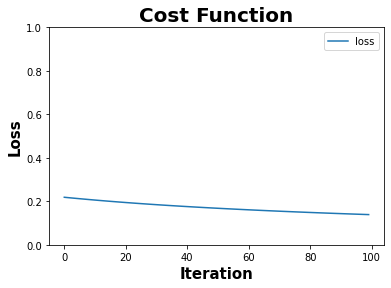

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 35 1 1 3
Accuracy = 0.95
Precesion = 0.75
Recall = 0.75
F1 = 0.75
F0.5 = 0.75
F2 = 0.75
Gmean = 0.8539125638299665
Balanced Accu. = 0.8611111111111112
################################################## 3th CV ##################################################


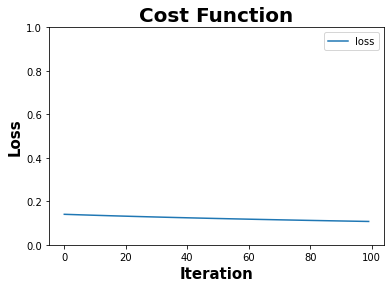

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 36 0 0 4
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0
################################################## 4th CV ##################################################


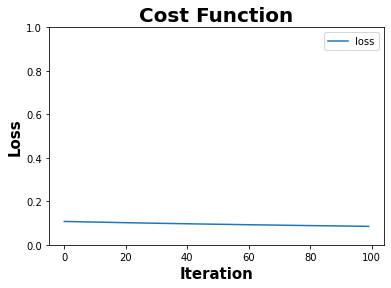

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 36 0 0 3
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0
################################################## 5th CV ##################################################


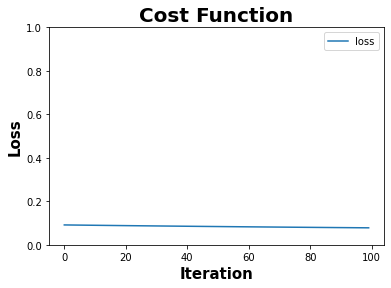

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 36 0 0 3
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0
################################################## 6th CV ##################################################


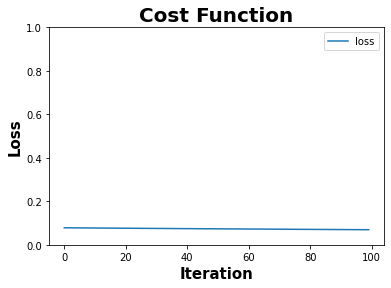

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 35 1 0 3
Accuracy = 0.9743589743589743
Precesion = 0.75
Recall = 1.0
F1 = 0.8571428571428571
F0.5 = 0.7894736842105263
F2 = 0.9375
Gmean = 0.9860132971832694
Balanced Accu. = 0.9861111111111112
################################################## 7th CV ##################################################


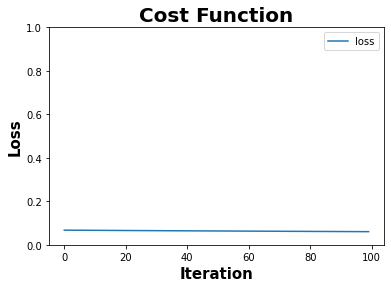

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 35 1 0 3
Accuracy = 0.9743589743589743
Precesion = 0.75
Recall = 1.0
F1 = 0.8571428571428571
F0.5 = 0.7894736842105263
F2 = 0.9375
Gmean = 0.9860132971832694
Balanced Accu. = 0.9861111111111112
################################################## 8th CV ##################################################


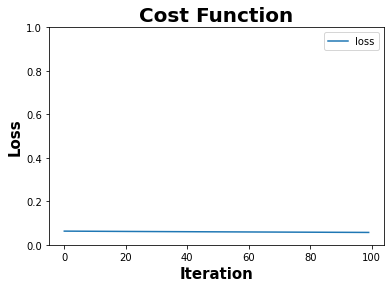

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 34 1 0 4
Accuracy = 0.9743589743589743
Precesion = 0.8
Recall = 1.0
F1 = 0.8888888888888888
F0.5 = 0.8333333333333334
F2 = 0.9523809523809523
Gmean = 0.9856107606091623
Balanced Accu. = 0.9857142857142858
################################################## 9th CV ##################################################


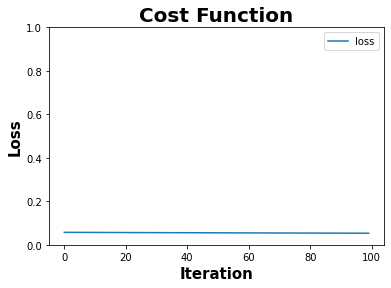

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 35 0 0 4
Accuracy = 1.0
Precesion = 1.0
Recall = 1.0
F1 = 1.0
F0.5 = 1.0
F2 = 1.0
Gmean = 1.0
Balanced Accu. = 1.0
################################################## 10th CV ##################################################


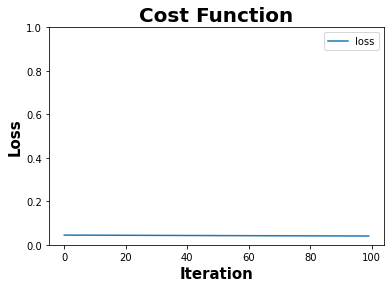

2/2 [==============================] - 0s 1ms/step
TN, FP, FN, TP: 35 0 1 3
Accuracy = 0.9743589743589743
Precesion = 1.0
Recall = 0.75
F1 = 0.8571428571428571
F0.5 = 0.9375
F2 = 0.7894736842105263
Gmean = 0.8660254037844386
Balanced Accu. = 0.875


In [344]:
bacc_acc = []
bacc_f1 = []
bacc_f5 = []
bacc_f2 = []
bacc_gmean = []
bacc_bacc = []

n_iter=0

###################### MLP (sigmoid // sigmoid // BCE) ############################## 
batch_size = int(X.shape[0]*0.9 * 0.5)  
print('batch_size: ', batch_size)
learning_rate=0.0001

model = Sequential()
model.add(Dense(1, input_dim=X.shape[1], kernel_initializer=kernel_initializer, activation='sigmoid'))
model.summary()
opt = optimizers.Adam(learning_rate = learning_rate)   # SGD(learning_rate=learning_rate, momentum=momentum)

for train_index, test_index in skf.split(cancer_df, cancer_df.iloc[:, -1]):
    n_iter += 1
    X_train = X.iloc[train_index]
    y_train= y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test= y.iloc[test_index]
    print('#'*50,'{0}th CV'.format(n_iter),'#'*50)
#     print('Labels for train:\n', label_train.value_counts())
#     print('Labels for test:\n', label_test.value_counts())
#     print(len(X_train), len(y_train), len(X_test), len(y_test))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_test = y_test.astype(float)
    
    model.compile(loss=SOL(score = 'bacc', distribution = 'cosine', mu = 0.5, delta = 0.1, mode = 'average'), optimizer=opt)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=len(X_train))
    plt.plot(history.history['loss'], label='loss')
    plt.ylim([0, 1])
    plt.xlabel('Iteration',fontweight="bold",fontsize = 15)
    plt.ylabel('Loss',fontweight="bold",fontsize = 15)
    plt.title("Cost Function",fontweight="bold",fontsize = 20)
    plt.legend()
    plt.show()    
    predicted = np.round(model.predict(X_test))
    TN = metrics.confusion_matrix(y_test, predicted)[0,0]
    FP = metrics.confusion_matrix(y_test, predicted)[0,1]
    FN = metrics.confusion_matrix(y_test, predicted)[1,0]
    TP = metrics.confusion_matrix(y_test, predicted)[1,1]
    print("TN, FP, FN, TP:", TN, FP, FN, TP)
    print('Accuracy =', (TP+TN)/(TP+TN+FP+FN))
    print('Precesion =', TP/(TP+FP))
    print('Recall =', TP/(TP+FN))
    print('F1 =', TP / (TP + 0.5*(FP+FN)))
    print('F0.5 =', TP / (TP + 0.8*FP + 0.2*FN))
    print('F2 =', TP / (TP + 0.2*FP + 0.8*FN))
    print('Gmean =', ((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    print('Balanced Accu. =', 0.5*(TP/(TP+FN) + TN/(TN+FP)))
    bacc_acc.append((TP+TN)/(TP+TN+FP+FN))
    bacc_f1.append(TP / (TP + 0.5*(FP+FN)))
    bacc_f5.append(TP / (TP + 0.8*FP + 0.2*FN))
    bacc_f2.append(TP / (TP + 0.2*FP + 0.8*FN))
    bacc_gmean.append(((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    bacc_bacc.append(0.5*(TP/(TP+FN) + TN/(TN+FP)))    

In [345]:
res['BAim'] = [np.mean(bacc_acc), np.mean(bacc_f1), np.mean(bacc_f5), np.mean(bacc_f2), np.mean(bacc_gmean), np.mean(bacc_bacc)]
res

,Delta,BCE,AccAim,F1Aim,F.5Aim,F2Aim,GAim,BAim
Acc,0,0,0.979808,0.982372,0,0,0,0.977244
F1,0,0,0.908045,0.922330,0,0,0,0.893759
F.5,0,0,0.893531,0.914583,0,0,0,0.872478
F2,0,0,0.929892,0.936142,0,0,0,0.923642
Gmean,0,0,0.964899,0.966298,0,0,0,0.963500
B_Acc,0,0,0.966627,0.968016,0,0,0,0.965238


# 4. Diabetes Prediction Data (8d / 100000)

In [384]:
# class 'B' = Benign, class 'M' = Malignant
diab_df = pd.read_csv('diabetes_prediction_dataset.csv')
diab_df.shape

(100000, 9)

In [385]:
diab_df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [386]:
diab_df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [387]:
# Female = 0, Male = 1, other = 2
gen_encoded, gen_class = pd.factorize(diab_df['gender'])
print(gen_class)
gen_encoded

Index(['Female', 'Male', 'Other'], dtype='object')


array([0, 0, 1, ..., 1, 0, 0])

In [388]:
# Female = 0, Male = 1, other = 2
pd.Series(gen_encoded).value_counts()

0    58552
1    41430
2       18
dtype: int64

In [389]:
diab_df['gender'] = gen_encoded
diab_df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,1,never,25.19,6.6,140,0
1,0,54.0,0,0,No Info,27.32,6.6,80,0
2,1,28.0,0,0,never,27.32,5.7,158,0
3,0,36.0,0,0,current,23.45,5.0,155,0
4,1,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,0,80.0,0,0,No Info,27.32,6.2,90,0
99996,0,2.0,0,0,No Info,17.37,6.5,100,0
99997,1,66.0,0,0,former,27.83,5.7,155,0
99998,0,24.0,0,0,never,35.42,4.0,100,0


In [390]:
# never = 0, Info = 1, current = 2, former=3, ever=4, not current=5
smo_encoded, smo_class = pd.factorize(diab_df['smoking_history'])
print(smo_class)
smo_encoded

Index(['never', 'No Info', 'current', 'former', 'ever', 'not current'], dtype='object')


array([0, 1, 0, ..., 3, 0, 2])

In [391]:
# never = 0, Info = 1, current = 2, former=3, ever=4, not current=5
pd.Series(smo_encoded).value_counts()

1    35816
0    35095
3     9352
2     9286
5     6447
4     4004
dtype: int64

In [392]:
diab_df['smoking_history'] = smo_encoded
diab_df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,1,0,25.19,6.6,140,0
1,0,54.0,0,0,1,27.32,6.6,80,0
2,1,28.0,0,0,0,27.32,5.7,158,0
3,0,36.0,0,0,2,23.45,5.0,155,0
4,1,76.0,1,1,2,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,0,80.0,0,0,1,27.32,6.2,90,0
99996,0,2.0,0,0,1,17.37,6.5,100,0
99997,1,66.0,0,0,3,27.83,5.7,155,0
99998,0,24.0,0,0,0,35.42,4.0,100,0


In [393]:
diab_df.describe()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.414660,41.885856,0.07485,0.039420,1.306950,27.320767,5.527507,138.058060,0.085000
std,0.493031,22.516840,0.26315,0.194593,1.454501,6.636783,1.070672,40.708136,0.278883
min,0.000000,0.080000,0.00000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,0.000000,24.000000,0.00000,0.000000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,0.000000,43.000000,0.00000,0.000000,1.000000,27.320000,5.800000,140.000000,0.000000
75%,1.000000,60.000000,0.00000,0.000000,2.000000,29.580000,6.200000,159.000000,0.000000
max,2.000000,80.000000,1.00000,1.000000,5.000000,95.690000,9.000000,300.000000,1.000000


In [394]:
# Amount values largely varies.

# # Normalization
# card_df.iloc[:,:-1] = (card_df.iloc[:,:-1] - card_df.iloc[:,:-1].min())/(card_df.iloc[:,:-1].max() - card_df.iloc[:,:-1].min())

# Standardization
diab_df.iloc[:,:-1] = (diab_df.iloc[:,:-1] - diab_df.iloc[:,:-1].mean())/diab_df.iloc[:,:-1].std()

diab_df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,-0.841043,1.692695,-0.284438,4.936354,-0.898556,-0.321054,1.001701,0.047704,0
1,-0.841043,0.538004,-0.284438,-0.202577,-0.211035,-0.000116,1.001701,-1.426203,0
2,1.187228,-0.616688,-0.284438,-0.202577,-0.898556,-0.000116,0.161107,0.489876,0
3,-0.841043,-0.261398,-0.284438,-0.202577,0.476486,-0.583229,-0.492688,0.416181,0
4,1.187228,1.515050,3.515669,4.936354,0.476486,-1.081965,-0.679486,0.416181,0
...,...,...,...,...,...,...,...,...,...
99995,-0.841043,1.692695,-0.284438,-0.202577,-0.211035,-0.000116,0.628104,-1.180552,0
99996,-0.841043,-1.771379,-0.284438,-0.202577,-0.211035,-1.499336,0.908301,-0.934901,0
99997,1.187228,1.070938,-0.284438,-0.202577,1.164008,0.076729,0.161107,0.416181,0
99998,-0.841043,-0.794332,-0.284438,-0.202577,-0.898556,1.220355,-1.426681,-0.934901,0


In [395]:
res = pd.DataFrame({'Delta':[0, 0, 0, 0, 0, 0],
                    'BCE':[0, 0, 0, 0, 0, 0],
                    'AccAim':[0, 0, 0, 0, 0, 0],
                    'F1Aim':[0, 0, 0, 0, 0, 0],
                    'F.5Aim':[0, 0, 0, 0, 0, 0],
                    'F2Aim':[0, 0, 0, 0, 0, 0],
                    'GAim':[0, 0, 0, 0, 0, 0],
                    'BAim':[0, 0, 0, 0, 0, 0]}, index = ['Acc','F1','F.5','F2','Gmean','B_Acc'])

In [396]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state = 2)

X = diab_df.iloc[:, :-1]
y = diab_df.iloc[:, -1]

In [397]:
L = 73
hidden_node = 2
# momentum=0.9
activation = 'sigmoid'  
kernel_initializer=keras.initializers.Zeros
epochs=100

batch_size:  4500
Model: "sequential_102"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_102 (Dense)           (None, 1)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
################################################## 1th CV ##################################################


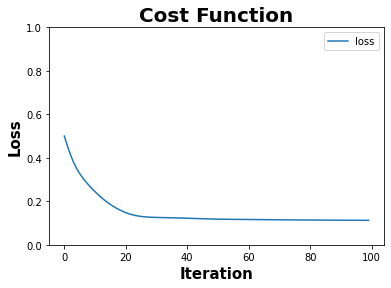

313/313 [==============================] - 0s 398us/step
TN, FP, FN, TP: 8394 756 299 551
Accuracy = 0.8945
Precesion = 0.42157612853863813
Recall = 0.648235294117647
F1 = 0.5108947612424664
F0.5 = 0.45327410332346163
F2 = 0.585298491608243
Gmean = 0.7711525019684426
Balanced Accu. = 0.7828061716489875
################################################## 2th CV ##################################################


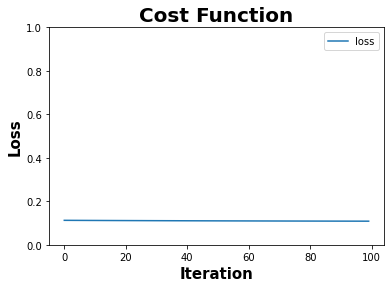

313/313 [==============================] - 0s 400us/step
TN, FP, FN, TP: 8391 759 264 586
Accuracy = 0.8977
Precesion = 0.4356877323420074
Recall = 0.6894117647058824
F1 = 0.5339407744874716
F0.5 = 0.47030497592295345
F2 = 0.6174920969441517
Gmean = 0.795125457856758
Balanced Accu. = 0.8032304725168756
################################################## 3th CV ##################################################


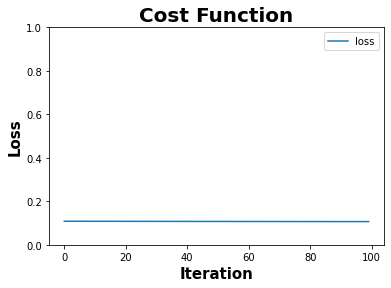

313/313 [==============================] - 0s 393us/step
TN, FP, FN, TP: 8397 753 287 563
Accuracy = 0.896
Precesion = 0.4278115501519757
Recall = 0.6623529411764706
F1 = 0.5198522622345337
F0.5 = 0.46041871115472677
F2 = 0.5969041560644613
Gmean = 0.7796438620236347
Balanced Accu. = 0.7900289296046288
################################################## 4th CV ##################################################


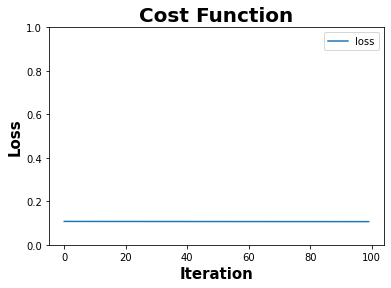

313/313 [==============================] - 0s 393us/step
TN, FP, FN, TP: 8442 708 252 598
Accuracy = 0.904
Precesion = 0.45788667687595713
Recall = 0.7035294117647058
F1 = 0.5547309833024119
F0.5 = 0.49226210075732624
F2 = 0.6353591160220994
Gmean = 0.8056626973310737
Balanced Accu. = 0.813076181292189
################################################## 5th CV ##################################################


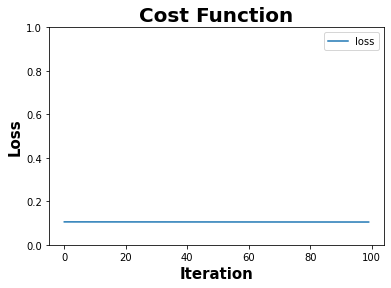

313/313 [==============================] - 0s 393us/step
TN, FP, FN, TP: 8346 804 260 590
Accuracy = 0.8936
Precesion = 0.4232424677187948
Recall = 0.6941176470588235
F1 = 0.5258467023172906
F0.5 = 0.4590725178960473
F2 = 0.6153525239883187
Gmean = 0.795692356341452
Balanced Accu. = 0.8031243972999036
################################################## 6th CV ##################################################


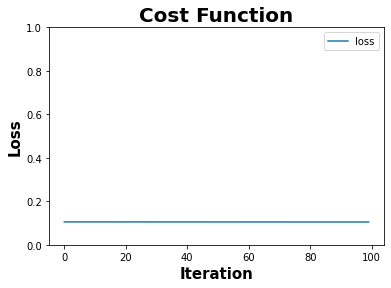

313/313 [==============================] - 0s 406us/step
TN, FP, FN, TP: 8388 762 254 596
Accuracy = 0.8984
Precesion = 0.43888070692194403
Recall = 0.7011764705882353
F1 = 0.5398550724637681
F0.5 = 0.47437121935689275
F2 = 0.6263135771332492
Gmean = 0.801737746207166
Balanced Accu. = 0.8089488910318225
################################################## 7th CV ##################################################


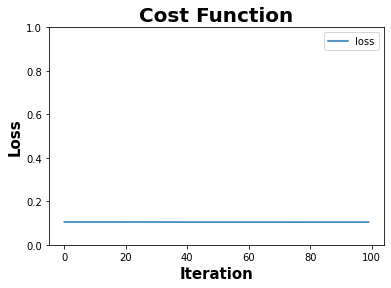

313/313 [==============================] - 0s 420us/step
TN, FP, FN, TP: 8388 762 259 591
Accuracy = 0.8979
Precesion = 0.43680709534368073
Recall = 0.6952941176470588
F1 = 0.5365410803449842
F0.5 = 0.47189396358990743
F2 = 0.6217126025667999
Gmean = 0.7983676693044062
Balanced Accu. = 0.8060077145612343
################################################## 8th CV ##################################################


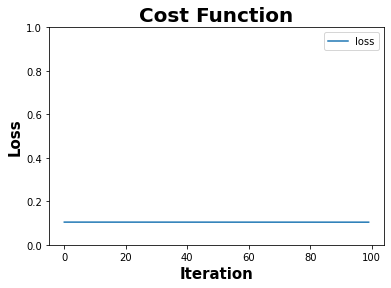

313/313 [==============================] - 0s 405us/step
TN, FP, FN, TP: 8372 778 254 596
Accuracy = 0.8968
Precesion = 0.43377001455604075
Recall = 0.7011764705882353
F1 = 0.5359712230215827
F0.5 = 0.46958714150646075
F2 = 0.624214495182237
Gmean = 0.8009727290995431
Balanced Accu. = 0.8080745740919318
################################################## 9th CV ##################################################


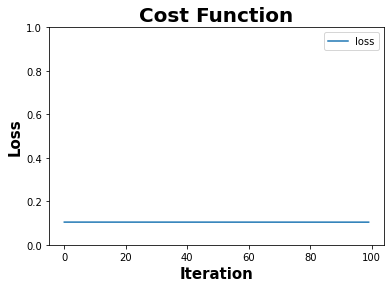

313/313 [==============================] - 0s 401us/step
TN, FP, FN, TP: 8408 742 256 594
Accuracy = 0.9002
Precesion = 0.44461077844311375
Recall = 0.6988235294117647
F1 = 0.5434583714547118
F0.5 = 0.47949628672909267
F2 = 0.6271114864864864
Gmean = 0.8013450601935629
Balanced Accu. = 0.8088653166184507
################################################## 10th CV ##################################################


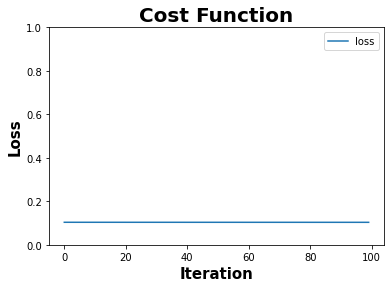

313/313 [==============================] - 0s 405us/step
TN, FP, FN, TP: 8339 811 250 600
Accuracy = 0.8939
Precesion = 0.42523033309709424
Recall = 0.7058823529411765
F1 = 0.5307386112339673
F0.5 = 0.46196489066830915
F2 = 0.6235709831635834
Gmean = 0.8020706086939988
Balanced Accu. = 0.8086242365798779


In [407]:
acc_acc = []
acc_f1 = []
acc_f5 = []
acc_f2 = []
acc_gmean = []
acc_bacc = []


n_iter=0

###################### MLP (sigmoid // sigmoid // BCE) ############################## 
batch_size = int(X.shape[0]*0.9 * 0.05)  
print('batch_size: ', batch_size)
learning_rate=0.01

model = Sequential()
model.add(Dense(1, input_dim=X.shape[1], kernel_initializer=kernel_initializer, activation='sigmoid'))
model.summary()
opt = optimizers.Adam(learning_rate = learning_rate)   # SGD(learning_rate=learning_rate, momentum=momentum)

for train_index, test_index in skf.split(diab_df, diab_df.iloc[:, -1]):
    n_iter += 1
    X_train = X.iloc[train_index]
    y_train= y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test= y.iloc[test_index]
    print('#'*50,'{0}th CV'.format(n_iter),'#'*50)
#     print('Labels for train:\n', label_train.value_counts())
#     print('Labels for test:\n', label_test.value_counts())
#     print(len(X_train), len(y_train), len(X_test), len(y_test))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_test = y_test.astype(float)
    
    model.compile(loss=SOL(score = 'accuracy', distribution = 'cosine', mu = 0.5, delta = 0.1, mode = 'average'), optimizer=opt)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=len(X_train))
    plt.plot(history.history['loss'], label='loss')
    plt.ylim([0, 1])
    plt.xlabel('Iteration',fontweight="bold",fontsize = 15)
    plt.ylabel('Loss',fontweight="bold",fontsize = 15)
    plt.title("Cost Function",fontweight="bold",fontsize = 20)
    plt.legend()
    plt.show()    
    predicted = np.round(model.predict(X_test))
    TN = metrics.confusion_matrix(y_test, predicted)[0,0]
    FP = metrics.confusion_matrix(y_test, predicted)[0,1]
    FN = metrics.confusion_matrix(y_test, predicted)[1,0]
    TP = metrics.confusion_matrix(y_test, predicted)[1,1]
    print("TN, FP, FN, TP:", TN, FP, FN, TP)
    print('Accuracy =', (TP+TN)/(TP+TN+FP+FN))
    print('Precesion =', TP/(TP+FP))
    print('Recall =', TP/(TP+FN))
    print('F1 =', TP / (TP + 0.5*(FP+FN)))
    print('F0.5 =', TP / (TP + 0.8*FP + 0.2*FN))
    print('F2 =', TP / (TP + 0.2*FP + 0.8*FN))
    print('Gmean =', ((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    print('Balanced Accu. =', 0.5*(TP/(TP+FN) + TN/(TN+FP)))
    acc_acc.append((TP+TN)/(TP+TN+FP+FN))
    acc_f1.append(TP / (TP + 0.5*(FP+FN)))
    acc_f5.append(TP / (TP + 0.8*FP + 0.2*FN))
    acc_f2.append(TP / (TP + 0.2*FP + 0.8*FN))
    acc_gmean.append(((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    acc_bacc.append(0.5*(TP/(TP+FN) + TN/(TN+FP)))    

In [408]:
res['AccAim'] = [np.mean(acc_acc), np.mean(acc_f1), np.mean(acc_f5), np.mean(acc_f2), np.mean(acc_gmean), np.mean(acc_bacc)]
res

,Delta,BCE,AccAim,F1Aim,F.5Aim,F2Aim,GAim,BAim
Acc,0,0,0.897300,0.926630,0,0,0,0
F1,0,0,0.533183,0.632199,0,0,0,0
F.5,0,0,0.469265,0.599605,0,0,0,0
F2,0,0,0.617333,0.674936,0,0,0,0
Gmean,0,0,0.795177,0.820839,0,0,0,0
B_Acc,0,0,0.803279,0.830565,0,0,0,0


batch_size:  4500
Model: "sequential_103"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_103 (Dense)           (None, 1)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
################################################## 1th CV ##################################################


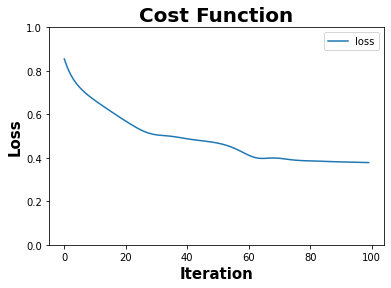

313/313 [==============================] - 0s 404us/step
TN, FP, FN, TP: 8820 330 276 574
Accuracy = 0.9394
Precesion = 0.6349557522123894
Recall = 0.6752941176470588
F1 = 0.6545039908779932
F0.5 = 0.6426332288401254
F2 = 0.66682156133829
Gmean = 0.8068080613319872
Balanced Accu. = 0.8196142719382835
################################################## 2th CV ##################################################


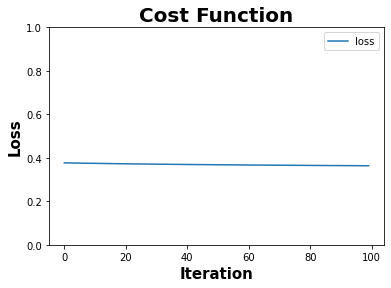

313/313 [==============================] - 0s 392us/step
TN, FP, FN, TP: 8777 373 259 591
Accuracy = 0.9368
Precesion = 0.6130705394190872
Recall = 0.6952941176470588
F1 = 0.6515986769570011
F0.5 = 0.6279218019549511
F2 = 0.6771310724106324
Gmean = 0.8166703336990204
Balanced Accu. = 0.8272645451623273
################################################## 3th CV ##################################################


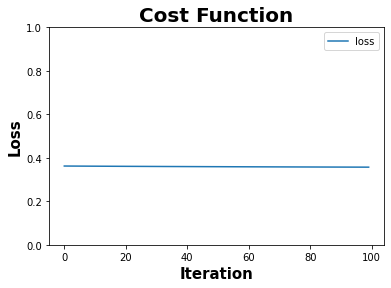

313/313 [==============================] - 0s 389us/step
TN, FP, FN, TP: 8799 351 284 566
Accuracy = 0.9365
Precesion = 0.6172300981461287
Recall = 0.6658823529411765
F1 = 0.6406338426711942
F0.5 = 0.6263833554670208
F2 = 0.6555478341440815
Gmean = 0.8002116402791122
Balanced Accu. = 0.8137608486017358
################################################## 4th CV ##################################################


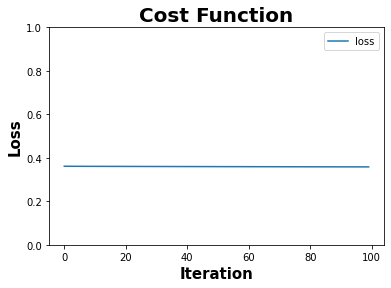

313/313 [==============================] - 0s 405us/step
TN, FP, FN, TP: 8827 323 245 605
Accuracy = 0.9432
Precesion = 0.6519396551724138
Recall = 0.711764705882353
F1 = 0.6805399325084365
F0.5 = 0.6630863656291099
F2 = 0.6989371534195933
Gmean = 0.8286368461649793
Balanced Accu. = 0.8382320797171328
################################################## 5th CV ##################################################


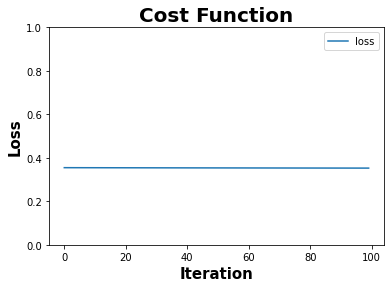

313/313 [==============================] - 0s 402us/step
TN, FP, FN, TP: 8772 378 267 583
Accuracy = 0.9355
Precesion = 0.6066597294484911
Recall = 0.6858823529411765
F1 = 0.6438431805632248
F0.5 = 0.6210055389859395
F2 = 0.6684246732400825
Gmean = 0.8108930515077846
Balanced Accu. = 0.8222854387656702
################################################## 6th CV ##################################################


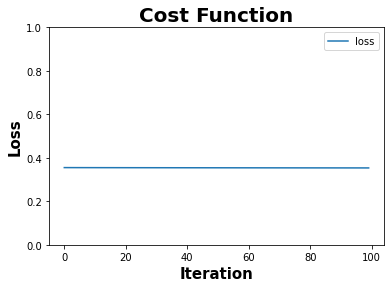

313/313 [==============================] - 0s 399us/step
TN, FP, FN, TP: 8786 364 246 604
Accuracy = 0.939
Precesion = 0.6239669421487604
Recall = 0.7105882352941176
F1 = 0.6644664466446645
F0.5 = 0.6395595086827615
F2 = 0.6913919413919415
Gmean = 0.8260266495187696
Balanced Accu. = 0.8354034072645451
################################################## 7th CV ##################################################


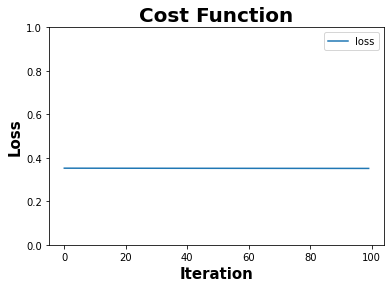

313/313 [==============================] - 0s 391us/step
TN, FP, FN, TP: 8793 357 259 591
Accuracy = 0.9384
Precesion = 0.6234177215189873
Recall = 0.6952941176470588
F1 = 0.657397107897664
F0.5 = 0.6365790607496769
F2 = 0.6796228150873965
Gmean = 0.8174143678665061
Balanced Accu. = 0.8281388621022179
################################################## 8th CV ##################################################


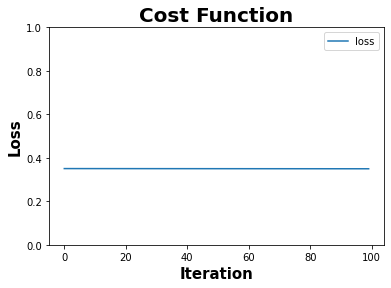

313/313 [==============================] - 0s 391us/step
TN, FP, FN, TP: 8775 375 265 585
Accuracy = 0.936
Precesion = 0.609375
Recall = 0.6882352941176471
F1 = 0.6464088397790055
F0.5 = 0.6236673773987207
F2 = 0.6708715596330275
Gmean = 0.8124216452093265
Balanced Accu. = 0.8236258437801349
################################################## 9th CV ##################################################


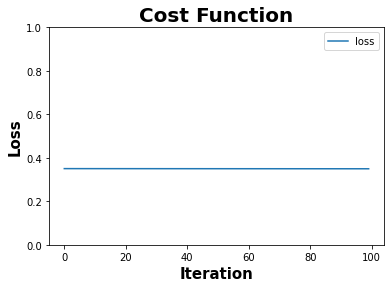

313/313 [==============================] - 0s 406us/step
TN, FP, FN, TP: 8798 352 268 582
Accuracy = 0.938
Precesion = 0.6231263383297645
Recall = 0.6847058823529412
F1 = 0.6524663677130045
F0.5 = 0.6345399040558221
F2 = 0.6714351638209507
Gmean = 0.8113971188477598
Balanced Accu. = 0.823117968498875
################################################## 10th CV ##################################################


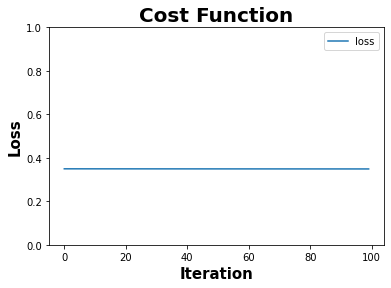

313/313 [==============================] - 0s 407us/step
TN, FP, FN, TP: 8776 374 261 589
Accuracy = 0.9365
Precesion = 0.6116303219106958
Recall = 0.6929411764705883
F1 = 0.6497517926089355
F0.5 = 0.6263292216078264
F2 = 0.6749942699977081
Gmean = 0.8152408718917549
Balanced Accu. = 0.8260334297653488


In [409]:
f1_acc = []
f1_f1 = []
f1_f5 = []
f1_f2 = []
f1_gmean = []
f1_bacc = []

n_iter=0

###################### MLP (sigmoid // sigmoid // BCE) ############################## 
batch_size = int(X.shape[0]*0.9 * 0.05)  
print('batch_size: ', batch_size)
learning_rate=0.01

model = Sequential()
model.add(Dense(1, input_dim=X.shape[1], kernel_initializer=kernel_initializer, activation='sigmoid'))
model.summary()
opt = optimizers.Adam(learning_rate = learning_rate)   # SGD(learning_rate=learning_rate, momentum=momentum)

for train_index, test_index in skf.split(diab_df, diab_df.iloc[:, -1]):
    n_iter += 1
    X_train = X.iloc[train_index]
    y_train= y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test= y.iloc[test_index]
    print('#'*50,'{0}th CV'.format(n_iter),'#'*50)
#     print('Labels for train:\n', label_train.value_counts())
#     print('Labels for test:\n', label_test.value_counts())
#     print(len(X_train), len(y_train), len(X_test), len(y_test))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_test = y_test.astype(float)
    
    model.compile(loss=SOL(score = 'f1_score', distribution = 'cosine', mu = 0.5, delta = 0.1, mode = 'average'), optimizer=opt)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=len(X_train))
    plt.plot(history.history['loss'], label='loss')
    plt.ylim([0, 1])
    plt.xlabel('Iteration',fontweight="bold",fontsize = 15)
    plt.ylabel('Loss',fontweight="bold",fontsize = 15)
    plt.title("Cost Function",fontweight="bold",fontsize = 20)
    plt.legend()
    plt.show()    
    predicted = np.round(model.predict(X_test))
    TN = metrics.confusion_matrix(y_test, predicted)[0,0]
    FP = metrics.confusion_matrix(y_test, predicted)[0,1]
    FN = metrics.confusion_matrix(y_test, predicted)[1,0]
    TP = metrics.confusion_matrix(y_test, predicted)[1,1]
    print("TN, FP, FN, TP:", TN, FP, FN, TP)
    print('Accuracy =', (TP+TN)/(TP+TN+FP+FN))
    print('Precesion =', TP/(TP+FP))
    print('Recall =', TP/(TP+FN))
    print('F1 =', TP / (TP + 0.5*(FP+FN)))
    print('F0.5 =', TP / (TP + 0.8*FP + 0.2*FN))
    print('F2 =', TP / (TP + 0.2*FP + 0.8*FN))
    print('Gmean =', ((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    print('Balanced Accu. =', 0.5*(TP/(TP+FN) + TN/(TN+FP)))
    f1_acc.append((TP+TN)/(TP+TN+FP+FN))
    f1_f1.append(TP / (TP + 0.5*(FP+FN)))
    f1_f5.append(TP / (TP + 0.8*FP + 0.2*FN))
    f1_f2.append(TP / (TP + 0.2*FP + 0.8*FN))
    f1_gmean.append(((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    f1_bacc.append(0.5*(TP/(TP+FN) + TN/(TN+FP)))    

In [410]:
res['F1Aim'] = [np.mean(f1_acc), np.mean(f1_f1), np.mean(f1_f5), np.mean(f1_f2), np.mean(f1_gmean), np.mean(f1_bacc)]
res

,Delta,BCE,AccAim,F1Aim,F.5Aim,F2Aim,GAim,BAim
Acc,0,0,0.897300,0.937930,0,0,0,0
F1,0,0,0.533183,0.654161,0,0,0,0
F.5,0,0,0.469265,0.634171,0,0,0,0
F2,0,0,0.617333,0.675518,0,0,0,0
Gmean,0,0,0.795177,0.814572,0,0,0,0
B_Acc,0,0,0.803279,0.825748,0,0,0,0


batch_size:  45000
Model: "sequential_94"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_94 (Dense)            (None, 1)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
################################################## 1th CV ##################################################


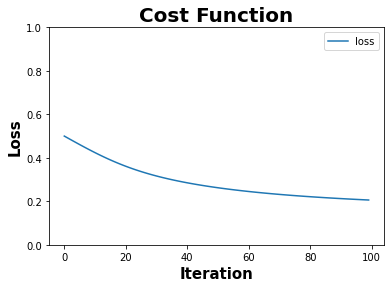

313/313 [==============================] - 0s 391us/step
TN, FP, FN, TP: 7606 1544 79 771
Accuracy = 0.8377
Precesion = 0.3330453563714903
Recall = 0.9070588235294118
F1 = 0.4872037914691943
F0.5 = 0.38130563798219586
F2 = 0.6745406824146981
Gmean = 0.8683310675173467
Balanced Accu. = 0.8691578270652524
################################################## 2th CV ##################################################


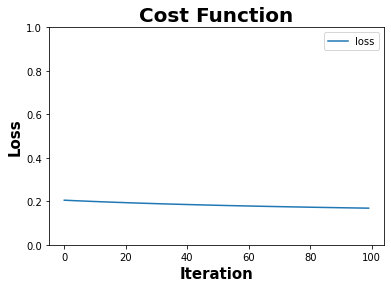

313/313 [==============================] - 0s 416us/step
TN, FP, FN, TP: 7834 1316 99 751
Accuracy = 0.8585
Precesion = 0.3633284954039671
Recall = 0.8835294117647059
F1 = 0.5149125814192663
F0.5 = 0.4118227681509103
F2 = 0.6868483629047009
Gmean = 0.8697446024074583
Balanced Accu. = 0.8698521375763419
################################################## 3th CV ##################################################


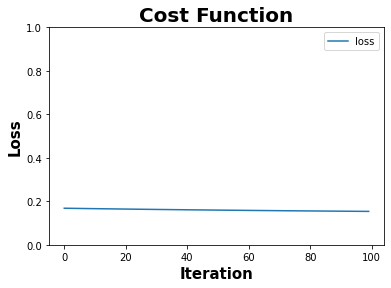

313/313 [==============================] - 0s 399us/step
TN, FP, FN, TP: 7989 1161 99 751
Accuracy = 0.874
Precesion = 0.39278242677824265
Recall = 0.8835294117647059
F1 = 0.5438088341781318
F0.5 = 0.4418686749823488
F2 = 0.7068900602409638
Gmean = 0.8783066463892952
Balanced Accu. = 0.8783220829315332
################################################## 4th CV ##################################################


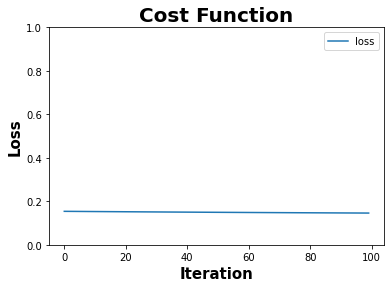

313/313 [==============================] - 0s 391us/step
TN, FP, FN, TP: 8008 1142 100 750
Accuracy = 0.8758
Precesion = 0.3964059196617336
Recall = 0.8823529411764706
F1 = 0.5470459518599562
F0.5 = 0.4454739843193158
F2 = 0.7086167800453514
Gmean = 0.878764803321351
Balanced Accu. = 0.8787720990035358
################################################## 5th CV ##################################################


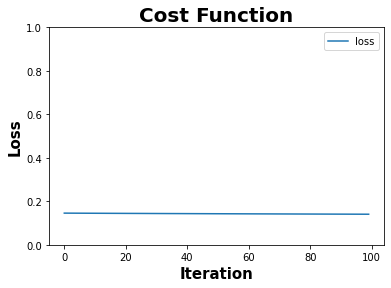

313/313 [==============================] - 0s 412us/step
TN, FP, FN, TP: 8025 1125 96 754
Accuracy = 0.8779
Precesion = 0.4012772751463544
Recall = 0.8870588235294118
F1 = 0.5525833638695493
F0.5 = 0.4506335166148697
F2 = 0.714150407274105
Gmean = 0.8820398030015846
Balanced Accu. = 0.8820540019286403
################################################## 6th CV ##################################################


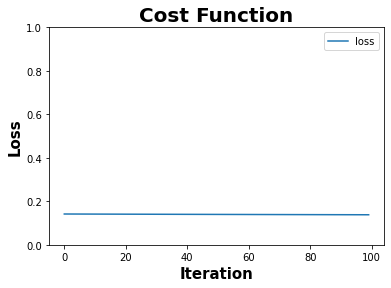

313/313 [==============================] - 0s 404us/step
TN, FP, FN, TP: 8086 1064 83 767
Accuracy = 0.8853
Precesion = 0.4188967777170945
Recall = 0.9023529411764706
F1 = 0.5721745617306975
F0.5 = 0.46917054073892833
F2 = 0.7331294207608487
Gmean = 0.8929857746346103
Balanced Accu. = 0.893034394085503
################################################## 7th CV ##################################################


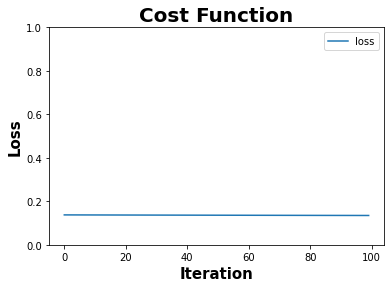

313/313 [==============================] - 0s 393us/step
TN, FP, FN, TP: 7988 1162 84 766
Accuracy = 0.8754
Precesion = 0.39730290456431533
Recall = 0.9011764705882352
F1 = 0.5514758819294456
F0.5 = 0.44732539126372345
F2 = 0.7188438438438439
Gmean = 0.8869791335116725
Balanced Accu. = 0.8870909675345549
################################################## 8th CV ##################################################


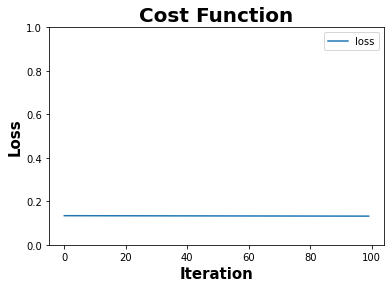

313/313 [==============================] - 0s 402us/step
TN, FP, FN, TP: 8007 1143 101 749
Accuracy = 0.8756
Precesion = 0.39587737843551796
Recall = 0.8811764705882353
F1 = 0.5463165572574763
F0.5 = 0.44488001900688995
F2 = 0.7076719576719576
Gmean = 0.8781239316544461
Balanced Accu. = 0.8781292189006751
################################################## 9th CV ##################################################


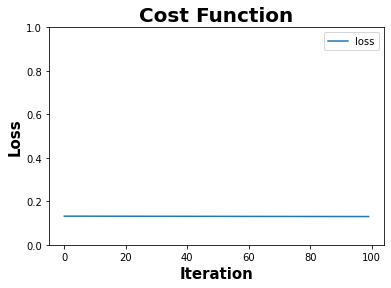

313/313 [==============================] - 0s 403us/step
TN, FP, FN, TP: 8023 1127 107 743
Accuracy = 0.8766
Precesion = 0.39732620320855616
Recall = 0.8741176470588236
F1 = 0.5463235294117647
F0.5 = 0.4459783913565426
F2 = 0.7049335863377609
Gmean = 0.8754730731989969
Balanced Accu. = 0.8754741240758599
################################################## 10th CV ##################################################


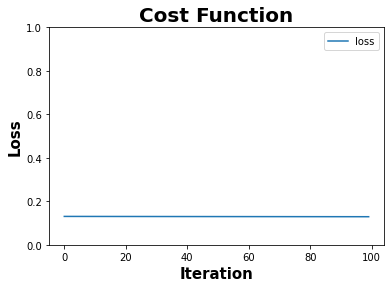

313/313 [==============================] - 0s 396us/step
TN, FP, FN, TP: 8003 1147 89 761
Accuracy = 0.8764
Precesion = 0.39884696016771487
Recall = 0.8952941176470588
F1 = 0.551849166062364
F0.5 = 0.44859702900259374
F2 = 0.7168425018839488
Gmean = 0.8849092339321002
Balanced Accu. = 0.8849694631951142


In [382]:
bacc_acc = []
bacc_f1 = []
bacc_f5 = []
bacc_f2 = []
bacc_gmean = []
bacc_bacc = []


n_iter=0

###################### MLP (sigmoid // sigmoid // BCE) ############################## 
batch_size = int(X.shape[0]*0.9 * 0.5)  
print('batch_size: ', batch_size)
learning_rate=0.001

model = Sequential()
model.add(Dense(1, input_dim=X.shape[1], kernel_initializer=kernel_initializer, activation='sigmoid'))
model.summary()
opt = optimizers.Adam(learning_rate = learning_rate)   # SGD(learning_rate=learning_rate, momentum=momentum)

for train_index, test_index in skf.split(diab_df, diab_df.iloc[:, -1]):
    n_iter += 1
    X_train = X.iloc[train_index]
    y_train= y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test= y.iloc[test_index]
    print('#'*50,'{0}th CV'.format(n_iter),'#'*50)
#     print('Labels for train:\n', label_train.value_counts())
#     print('Labels for test:\n', label_test.value_counts())
#     print(len(X_train), len(y_train), len(X_test), len(y_test))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_test = y_test.astype(float)
    
    model.compile(loss=SOL(score = 'bacc', distribution = 'cosine', mu = 0.5, delta = 0.1, mode = 'average'), optimizer=opt)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=len(X_train))
    plt.plot(history.history['loss'], label='loss')
    plt.ylim([0, 1])
    plt.xlabel('Iteration',fontweight="bold",fontsize = 15)
    plt.ylabel('Loss',fontweight="bold",fontsize = 15)
    plt.title("Cost Function",fontweight="bold",fontsize = 20)
    plt.legend()
    plt.show()    
    predicted = np.round(model.predict(X_test))
    TN = metrics.confusion_matrix(y_test, predicted)[0,0]
    FP = metrics.confusion_matrix(y_test, predicted)[0,1]
    FN = metrics.confusion_matrix(y_test, predicted)[1,0]
    TP = metrics.confusion_matrix(y_test, predicted)[1,1]
    print("TN, FP, FN, TP:", TN, FP, FN, TP)
    print('Accuracy =', (TP+TN)/(TP+TN+FP+FN))
    print('Precesion =', TP/(TP+FP))
    print('Recall =', TP/(TP+FN))
    print('F1 =', TP / (TP + 0.5*(FP+FN)))
    print('F0.5 =', TP / (TP + 0.8*FP + 0.2*FN))
    print('F2 =', TP / (TP + 0.2*FP + 0.8*FN))
    print('Gmean =', ((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    print('Balanced Accu. =', 0.5*(TP/(TP+FN) + TN/(TN+FP)))
    bacc_acc.append((TP+TN)/(TP+TN+FP+FN))
    bacc_f1.append(TP / (TP + 0.5*(FP+FN)))
    bacc_f5.append(TP / (TP + 0.8*FP + 0.2*FN))
    bacc_f2.append(TP / (TP + 0.2*FP + 0.8*FN))
    bacc_gmean.append(((TP/(TP+FN)) * (TN/(TN+FP)))**0.5)
    bacc_bacc.append(0.5*(TP/(TP+FN) + TN/(TN+FP)))    

In [383]:
res['BAim'] = [np.mean(bacc_acc), np.mean(bacc_f1), np.mean(bacc_f5), np.mean(bacc_f2), np.mean(bacc_gmean), np.mean(bacc_bacc)]
res

,Delta,BCE,AccAim,F1Aim,F.5Aim,F2Aim,GAim,BAim
Acc,0,0,0.897990,0.942200,0,0,0,0.871320
F1,0,0,0.543939,0.670434,0,0,0,0.541369
F.5,0,0,0.475567,0.664533,0,0,0,0.438706
F2,0,0,0.635328,0.679054,0,0,0,0.707247
Gmean,0,0,0.809091,0.813986,0,0,0,0.879566
B_Acc,0,0,0.815235,0.826107,0,0,0,0.879686
